MEDICAL APPOINTMENT ATTENDANCE PREDICTION 

Welcome to this notebook !!

The main objective of this project is to determine wheter or not the patients who have scheduled appointments for radiological service will attend

We use demographic data of the patients, which have been previously anonymized and internal data from the hospital.

Let us start this beautiful journey !!

#Librerias Necesarias

In [4]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

#from yellowbrick.classifier import ClassificationReport
#from yellowbrick.classifier import ClassPredictionError

# Cargar PATDATA - Base de datos de citas


In [5]:
#Load scheduling data supplied by the service
data=pd.read_excel('db_Citas_RM.XLSX')

In [6]:
#convert data type
pd.set_option('display.max_columns', None)
data['Edad'] = data['Edad'].round().astype(int)
data.head(5) 

Fecha      Hora  Hora.1 Día de la semana  \
0 2018-01-02  08:30:00       8           martes   
1 2018-01-02  16:05:00      16           martes   
2 2018-01-02  17:15:00      17           martes   
3 2018-01-02  11:25:00      11           martes   
4 2018-01-02  10:50:00      10           martes   

   Horario laboral \n(Si = 1; No = 0) Franja horaria  Día festivo  \
0                                   1         6 - 12            0   
1                                   1        12 - 18            0   
2                                   1        12 - 18            0   
3                                   1         6 - 12            0   
4                                   1         6 - 12            0   

   Num Dcto Modif  Edad Fecha crea. cita  Tiempo entre creación cita y cita  \
0               1     2       2017-11-01                                 62   
1               2    54       2018-01-02                                  0   
2               3    17       2017-12-18                                 15   
3               4    56       2018-01-02                                  0   
4               5    30       2017-12-29                                  4   

  Agente Cita  Confirmado por email  Paciente NO ubicado  Confirmado FAMILIAR  \
0   PGRISALES                     0                    0                    0   
1   PGRISALES                     0                    0                    0   
2    SGALARZA                     0                    0                    1   
3    SGALARZA                     0                    0                    0   
4      YGARAY                     0                    0                    0   

   Confirmado PACIENTE  Confirmado  Antecedente No Show  \
0                    0           0                    0   
1                    0           0                    0   
2                    0           1                    0   
3                    0           0                    0   
4                    0           0                    0   

   Antecedente Cita Asistida  Antecedente Cita Cancelada  Estudio Simple  \
0                          0                           0               1   
1                          0                           0               1   
2                          0                           0               1   
3                          0                           0               1   
4                          0                           0               1   

  Parte del Cuerpo  Anestesia  Reprogramación  Reprogramación por paciente  \
0          CEREBRO          1               1                            1   
1             MMII          0               0                            0   
2          COLUMNA          0               0                            0   
3             MMSS          0               0                            0   
4          COLUMNA          0               0                            0   

   Cita adelantada Aseguradora   Voluntario RS / RC  \
0                0         EPS  Obligatorio      RC   
1                0   PREPAGADA   Voluntario      RC   
2                0   PREPAGADA   Voluntario      RC   
3                0        OTRO   Voluntario      OT   
4                0      PÓLIZA   Voluntario      RC   

  Tipo de Cita VARIABLE OBJETIVO  
0                       ATENDIDA  
1                       ATENDIDA  
2                       ATENDIDA  
3                       ATENDIDA  
4                       ATENDIDA

In [7]:
# We delete some columns that do not add value. Column confirmado is the sum of the previous ones

data= data.drop(columns=['Fecha', 'Hora','Agente Cita','Fecha crea. cita','Confirmado por email','Paciente NO ubicado','Confirmado FAMILIAR','Confirmado PACIENTE'])
data.head(5)

Hora.1 Día de la semana  Horario laboral \n(Si = 1; No = 0) Franja horaria  \
0       8           martes                                   1         6 - 12   
1      16           martes                                   1        12 - 18   
2      17           martes                                   1        12 - 18   
3      11           martes                                   1         6 - 12   
4      10           martes                                   1         6 - 12   

   Día festivo  Num Dcto Modif  Edad  Tiempo entre creación cita y cita  \
0            0               1     2                                 62   
1            0               2    54                                  0   
2            0               3    17                                 15   
3            0               4    56                                  0   
4            0               5    30                                  4   

   Confirmado  Antecedente No Show  Antecedente Cita Asistida  \
0           0                    0                          0   
1           0                    0                          0   
2           1                    0                          0   
3           0                    0                          0   
4           0                    0                          0   

   Antecedente Cita Cancelada  Estudio Simple Parte del Cuerpo  Anestesia  \
0                           0               1          CEREBRO          1   
1                           0               1             MMII          0   
2                           0               1          COLUMNA          0   
3                           0               1             MMSS          0   
4                           0               1          COLUMNA          0   

   Reprogramación  Reprogramación por paciente  Cita adelantada Aseguradora  \
0               1                            1                0         EPS   
1               0                            0                0   PREPAGADA   
2               0                            0                0   PREPAGADA   
3               0                            0                0        OTRO   
4               0                            0                0      PÓLIZA   

    Voluntario RS / RC Tipo de Cita VARIABLE OBJETIVO  
0  Obligatorio      RC                       ATENDIDA  
1   Voluntario      RC                       ATENDIDA  
2   Voluntario      RC                       ATENDIDA  
3   Voluntario      OT                       ATENDIDA  
4   Voluntario      RC                       ATENDIDA

In [8]:
data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29169 entries, 0 to 29168
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Hora.1                             29169 non-null  int64 
 1   Día de la semana                   29169 non-null  object
 2   Horario laboral 
(Si = 1; No = 0)  29169 non-null  int64 
 3   Franja horaria                     29169 non-null  object
 4   Día festivo                        29169 non-null  int64 
 5   Num Dcto Modif                     29169 non-null  int64 
 6   Edad                               29169 non-null  int32 
 7   Tiempo entre creación cita y cita  29169 non-null  int64 
 8   Confirmado                         29169 non-null  int64 
 9   Antecedente No Show                29169 non-null  int64 
 10  Antecedente Cita Asistida          29169 non-null  int64 
 11  Antecedente Cita Cancelada         29169 non-null  int64 
 12  Estu

In [9]:
# Data imputation using mode
columnas=['RS / RC', 'Aseguradora', 'Voluntario']
for columna in columnas:
  moda = data[columna].mode()[0]
  data[columna].fillna(moda, inplace=True)

In [10]:
data.head(84)

Hora.1 Día de la semana  Horario laboral \n(Si = 1; No = 0)  \
0        8           martes                                   1   
1       16           martes                                   1   
2       17           martes                                   1   
3       11           martes                                   1   
4       10           martes                                   1   
..     ...              ...                                 ...   
79       8           jueves                                   1   
80      11           jueves                                   1   
81       8           jueves                                   1   
82      12          viernes                                   1   
83      19          viernes                                   0   

   Franja horaria  Día festivo  Num Dcto Modif  Edad  \
0          6 - 12            0               1     2   
1         12 - 18            0               2    54   
2         12 - 18            0               3    17   
3          6 - 12            0               4    56   
4          6 - 12            0               5    30   
..            ...          ...             ...   ...   
79         6 - 12            0              80     2   
80         6 - 12            0              56    37   
81         6 - 12            0              81    15   
82        12 - 18            0              82    72   
83        18 - 00            0              83    42   

    Tiempo entre creación cita y cita  Confirmado  Antecedente No Show  \
0                                  62           0                    0   
1                                   0           0                    0   
2                                  15           1                    0   
3                                   0           0                    0   
4                                   4           0                    0   
..                                ...         ...                  ...   
79                                 24           0                    0   
80                                  1           0                    0   
81                                 13           0                    0   
82                                  3           1                    0   
83                                  1           0                    0   

    Antecedente Cita Asistida  Antecedente Cita Cancelada  Estudio Simple  \
0                           0                           0               1   
1                           0                           0               1   
2                           0                           0               1   
3                           0                           0               1   
4                           0                           0               1   
..                        ...                         ...             ...   
79                          0                           0               1   
80                          0                           0               1   
81                          0                           0               1   
82                          0                           0               1   
83                          0                           0               1   

   Parte del Cuerpo  Anestesia  Reprogramación  Reprogramación por paciente  \
0           CEREBRO          1               1                            1   
1              MMII          0               0                            0   
2           COLUMNA          0               0                            0   
3              MMSS          0               0                            0   
4           COLUMNA          0               0                            0   
..              ...        ...             ...                          ...   
79          COLUMNA          1               0                            0   
80             MMII          0               0                            0   
8

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29169 entries, 0 to 29168
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Hora.1                             29169 non-null  int64 
 1   Día de la semana                   29169 non-null  object
 2   Horario laboral 
(Si = 1; No = 0)  29169 non-null  int64 
 3   Franja horaria                     29169 non-null  object
 4   Día festivo                        29169 non-null  int64 
 5   Num Dcto Modif                     29169 non-null  int64 
 6   Edad                               29169 non-null  int32 
 7   Tiempo entre creación cita y cita  29169 non-null  int64 
 8   Confirmado                         29169 non-null  int64 
 9   Antecedente No Show                29169 non-null  int64 
 10  Antecedente Cita Asistida          29169 non-null  int64 
 11  Antecedente Cita Cancelada         29169 non-null  int64 
 12  Estu

In [12]:
# checking the statistical insights 
data.describe()

Hora.1  Horario laboral \n(Si = 1; No = 0)   Día festivo  \
count  29169.00000                        29169.000000  29169.000000   
mean      12.62203                            0.623162      0.028832   
std        4.51736                            0.484602      0.167337   
min        0.00000                            0.000000      0.000000   
25%        9.00000                            0.000000      0.000000   
50%       13.00000                            1.000000      0.000000   
75%       16.00000                            1.000000      0.000000   
max       23.00000                            1.000000      1.000000   

       Num Dcto Modif          Edad  Tiempo entre creación cita y cita  \
count    29169.000000  29169.000000                       29169.000000   
mean     10216.068463     49.256917                          12.004148   
std       6289.276246     19.106165                          16.505151   
min          1.000000      0.000000                         -65.000000   
25%       4683.000000     36.000000                           4.000000   
50%       9908.000000     52.000000                           8.000000   
75%      15566.000000     63.000000                          15.000000   
max      21793.000000     99.000000                        1309.000000   

         Confirmado  Antecedente No Show  Antecedente Cita Asistida  \
count  29169.000000         29169.000000               29169.000000   
mean       0.526312             0.066406                   0.235627   
std        0.499316             0.283746                   0.590005   
min        0.000000             0.000000                   0.000000   
25%        0.000000             0.000000                   0.000000   
50%        1.000000             0.000000                   0.000000   
75%        1.000000             0.000000                   0.000000   
max        1.000000             5.000000                   9.000000   

       Antecedente Cita Cancelada  Estudio Simple     Anestesia  \
count                29169.000000    29169.000000  29169.000000   
mean                     0.057870        0.426686      0.052761   
std                      0.301095        0.494604      0.223561   
min                      0.000000        0.000000      0.000000   
25%                      0.000000        0.000000      0.000000   
50%                      0.000000        0.000000      0.000000   
75%                      0.000000        1.000000      0.000000   
max                     12.000000        1.000000      1.000000   

       Reprogramación  Reprogramación por paciente  Cita adelantada  
count    29169.000000                 29169.000000     29169.000000  
mean         0.141932                     0.075285         0.008776  
std          0.348986                     0.263856         0.093272  
min          0.000000                     0.000000         0.000000  
25%          0.000000                     0.000000         0.000000  
50%          0.000000                     0.000000         0.000000  
75%          0.000000                     0.000000         0.000000  
max          1.000000                     1.000000         1.000000

In [13]:
def verificar_valores_faltantes(df):
    # Verifica si hay valores faltantes en el DataFrame
    valores_faltantes = df.isnull().any().any()
    
    if valores_faltantes:
        print("El DataFrame contiene valores faltantes (NaN).")
        
        # Opcional: Mostrar las columnas con valores faltantes y el número de valores faltantes por columna
        print(df.isnull().sum())
    else:
        print("El DataFrame no contiene valores faltantes (NaN).")

# Supongamos que tu DataFrame se llama 'df'
verificar_valores_faltantes(data)

El DataFrame no contiene valores faltantes (NaN).


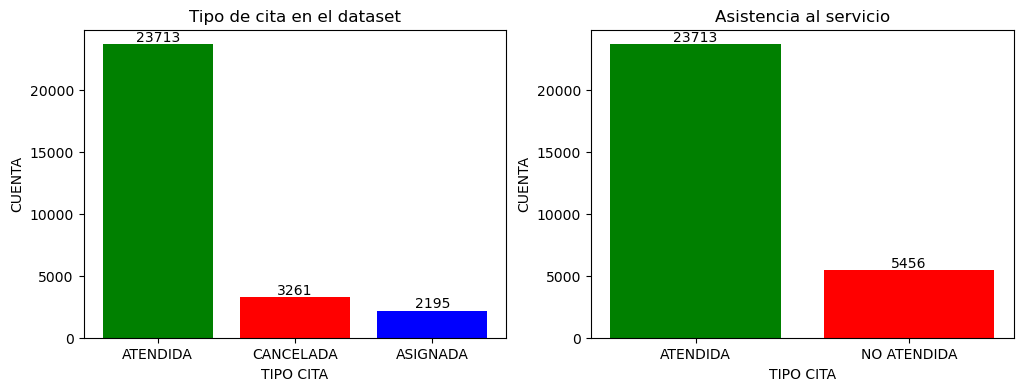

In [14]:
#We consider that both the classes asignada and cancelada represent a missed appointment 
#Here we create a graphic to determine how severe is the difference between classes

gender_counts = data['Tipo de Cita VARIABLE OBJETIVO'].value_counts()
gender_counts.index = ['ATENDIDA', 'CANCELADA', 'ASIGNADA']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(gender_counts.index, gender_counts.values, color=['green', 'red', 'blue'])

for i, count in enumerate(gender_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.xlabel('TIPO CITA')
plt.ylabel('CUENTA')
plt.title('Tipo de cita en el dataset')
#plt.show()

combi= gender_counts.values
combi[1]=combi[1]+combi[2]
combi=np.delete(combi,2,0)

combina= ['ATENDIDA', 'NO ATENDIDA']
plt.subplot(1, 2, 2)
plt.bar(combina, combi, color=['green', 'red'])

for i, count in enumerate(combi):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.xlabel('TIPO CITA')
plt.ylabel('CUENTA')
plt.title('Asistencia al servicio')
plt.show()

Here we notice that one of the challenges we have to address is the class imbalance
We will try 3 techniques that have demostrated to help when it comes to handle imbalanced data: Oversampling and undersampling 
SMOTE should be used after train/test split to avoid data leakage and over-optimistic performance evaluations 

# Cargar datos demográficos - Base de datos pacientes (información sociodemográfica y comunas de barrios)



In [15]:
# Load demographic info

data2=pd.read_excel('db_Citas_RM_patdata.XLSX')

In [16]:
data2.head()

Num Dcto Modif Fecha de nacimiento       Sexo     Grupo étnico  \
0             348          1964-07-21  Masculino              NaN   
1           10037          1927-03-18  Masculino              NaN   
2           11779          1932-01-06  Masculino  NingunoAnterior   
3           12679          1933-09-02  Masculino             Otro   
4           18080          1932-09-15  Masculino              NaN   

   Estrato socioeconómico  Comuna Municipio de residencia  \
0                     NaN     NaN         VALLE DEL CAUCA   
1                     NaN     NaN         VALLE DEL CAUCA   
2                     5.0    19.0         VALLE DEL CAUCA   
3                     6.0    22.0         VALLE DEL CAUCA   
4                     6.0    22.0         VALLE DEL CAUCA   

  Ciudad de residencia Barrio de residencia Codigo aseguradora  \
0                 CALI                  NaN         Particular   
1                 CALI                  NaN         Particular   
2                 CALI          PAMPA LINDA         1000000237   
3                 CALI       CLUB CAMPESTRE         1000000345   
4                 CALI  PARCELACIONES PANCE         1000000164   

                Seguridad social           Régimen salud  \
0                     Particular              Particular   
1                     Particular              Particular   
2            Coomeva Mp S.A. Oro  Emp Medicina Prepagada   
3  Compañia Seguros Bolivar S.A.            Aseguradoras   
4              Colsanitas Mp S.A  Emp Medicina Prepagada   

  Cotizante o beneficiario  
0                      NaN  
1                      NaN  
2     Ampar plan volun sal  
3     Ampar plan volun sal  
4     Ampar plan volun sal

In [17]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21793 entries, 0 to 21792
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Num Dcto Modif            21793 non-null  int64         
 1   Fecha de nacimiento       21771 non-null  datetime64[ns]
 2   Sexo                      21771 non-null  object        
 3   Grupo étnico              3277 non-null   object        
 4   Estrato socioeconómico    17980 non-null  float64       
 5   Comuna                    17997 non-null  float64       
 6   Municipio de residencia   21609 non-null  object        
 7   Ciudad de residencia      21647 non-null  object        
 8   Barrio de residencia      17999 non-null  object        
 9   Codigo aseguradora        21628 non-null  object        
 10  Seguridad social          21628 non-null  object        
 11  Régimen salud             21628 non-null  object        
 12  Cotizante o benefi

In [18]:
#We merge the databases using the shared column called 'Num Dcto Modif'

df = pd.merge(data, data2, on='Num Dcto Modif', how='inner')
df.head()
df.to_csv('df.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29171 entries, 0 to 29170
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Hora.1                             29171 non-null  int64         
 1   Día de la semana                   29171 non-null  object        
 2   Horario laboral 
(Si = 1; No = 0)  29171 non-null  int64         
 3   Franja horaria                     29171 non-null  object        
 4   Día festivo                        29171 non-null  int64         
 5   Num Dcto Modif                     29171 non-null  int64         
 6   Edad                               29171 non-null  int32         
 7   Tiempo entre creación cita y cita  29171 non-null  int64         
 8   Confirmado                         29171 non-null  int64         
 9   Antecedente No Show                29171 non-null  int64         
 10  Antecedente Cita Asistida         

Here we noticed that there are missing data, which could affect the performance of our ML model

# Data wrangling

In [20]:
# Complete missing values with mode
columnas=['Seguridad social', 'Régimen salud', 'Cotizante o beneficiario','RS / RC', 'Aseguradora', 'Voluntario','Estrato socioeconómico','Comuna', 'Sexo' ]
for columna in columnas:
  moda = df[columna].mode()[0]
  df[columna].fillna(moda, inplace=True)

df['Grupo étnico'].fillna('Otro', inplace=True)


# Completar valores faltantes en 'Municipio de residencia', 'Ciudad de residencia' y 'Barrio de residencia' con 'CALI'
df['Municipio de residencia'].fillna('CALI', inplace=True)
df['Ciudad de residencia'].fillna('CALI', inplace=True)
df['Barrio de residencia'].fillna('CALI', inplace=True)

# Verificar que los valores faltantes han sido llenados

In [21]:
def verificar_valores_faltantes(df):
    # Verifica si hay valores faltantes en el DataFrame
    valores_faltantes = df.isnull().any().any()
    
    if valores_faltantes:
        print("El DataFrame contiene valores faltantes (NaN).")
        
        # Opcional: Mostrar las columnas con valores faltantes y el número de valores faltantes por columna
        print(df.isnull().sum())
    else:
        print("El DataFrame no contiene valores faltantes (NaN).")

# Supongamos que tu DataFrame se llama 'df'
verificar_valores_faltantes(df)

El DataFrame contiene valores faltantes (NaN).
Hora.1                                  0
Día de la semana                        0
Horario laboral \n(Si = 1; No = 0)      0
Franja horaria                          0
Día festivo                             0
Num Dcto Modif                          0
Edad                                    0
Tiempo entre creación cita y cita       0
Confirmado                              0
Antecedente No Show                     0
Antecedente Cita Asistida               0
Antecedente Cita Cancelada              0
Estudio Simple                          0
Parte del Cuerpo                        0
Anestesia                               0
Reprogramación                          0
Reprogramación por paciente             0
Cita adelantada                         0
Aseguradora                             0
Voluntario                              0
RS / RC                                 0
Tipo de Cita VARIABLE OBJETIVO          0
Fecha de nacimiento          

In [22]:
# Manual encoding of some categorical variables for understanding's sake
df['Tipo de Cita VARIABLE OBJETIVO'] = df['Tipo de Cita VARIABLE OBJETIVO'].replace({
    'ATENDIDA': 0,
    'ASIGNADA': 1,
    'CANCELADA': 1
})

df['Franja horaria'] = df['Franja horaria'].replace({
    '6 - 12': 0,
    '12 - 18': 1,
    '18 - 00': 2,
    '0 - 6': 3
})

df['Día de la semana'] = df['Día de la semana'].replace({
    'lunes':0,
    'martes':1,
    'miércoles':2,
    'jueves':3,
    'viernes':4,
    'sábado':5,
    'domingo':6
})

In [23]:
df= df.drop(columns=['Fecha de nacimiento','Codigo aseguradora'])
df.head(10)

Hora.1  Día de la semana  Horario laboral \n(Si = 1; No = 0)  \
0       8                 1                                   1   
1      16                 1                                   1   
2      17                 1                                   1   
3      11                 1                                   1   
4      10                 1                                   1   
5      16                 1                                   1   
6       7                 1                                   1   
7       7                 3                                   1   
8      10                 1                                   1   
9      14                 1                                   1   

   Franja horaria  Día festivo  Num Dcto Modif  Edad  \
0               0            0               1     2   
1               1            0               2    54   
2               1            0               3    17   
3               0            0               4    56   
4               0            0               5    30   
5               1            0               6    62   
6               0            0               7    24   
7               0            0               7    25   
8               0            0               8    34   
9               1            0               9    36   

   Tiempo entre creación cita y cita  Confirmado  Antecedente No Show  \
0                                 62           0                    0   
1                                  0           0                    0   
2                                 15           1                    0   
3                                  0           0                    0   
4                                  4           0                    0   
5                                  0           0                    0   
6                                  4           0                    0   
7                                  9           1                    0   
8                                  5           0                    0   
9                                  0           0                    0   

   Antecedente Cita Asistida  Antecedente Cita Cancelada  Estudio Simple  \
0                          0                           0               1   
1                          0                           0               1   
2                          0                           0               1   
3                          0                           0               1   
4                          0                           0               1   
5                          0                           0               1   
6                          0                           0               0   
7                          1                           0               0   
8                          0                           0               0   
9                          0                           0               0   

  Parte del Cuerpo  Anestesia  Reprogramación  Reprogramación por paciente  \
0          CEREBRO          1               1                            1   
1             MMII          0               0                            0   
2          COLUMNA          0               0                            0   
3             MMSS          0               0                            0   
4          COLUMNA          0               0                            0   
5             MMSS          0               0                            0   
6             OTRO          0               0                            0   
7             OTRO          0               0                            0   
8             MMSS          0               0                            0   
9          COLUMNA          0               0                            0   

   Cita adelantada Aseguradora   Voluntario RS / RC  \
0                0         EPS  Obligatorio      RC   
1                0   PREPAGADA   Volun

In [24]:
df['Estrato socioeconómico'] = df['Estrato socioeconómico'].astype(int)
df['Comuna'] = df['Comuna'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29171 entries, 0 to 29170
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Hora.1                             29171 non-null  int64 
 1   Día de la semana                   29171 non-null  int64 
 2   Horario laboral 
(Si = 1; No = 0)  29171 non-null  int64 
 3   Franja horaria                     29171 non-null  int64 
 4   Día festivo                        29171 non-null  int64 
 5   Num Dcto Modif                     29171 non-null  int64 
 6   Edad                               29171 non-null  int32 
 7   Tiempo entre creación cita y cita  29171 non-null  int64 
 8   Confirmado                         29171 non-null  int64 
 9   Antecedente No Show                29171 non-null  int64 
 10  Antecedente Cita Asistida          29171 non-null  int64 
 11  Antecedente Cita Cancelada         29171 non-null  int64 
 12  Estu

In [25]:
#Save Preprocessed data
df= df.drop(columns=['Num Dcto Modif'])
#df.to_csv('final_data.csv')

In [35]:
df=pd.read_csv('final_data.csv')
df= df.drop(columns=['Num Dcto Modif'])

# Preprocessing 1.0

In [31]:
from sklearn.preprocessing import LabelEncoder
columns_to_encode = [
    'Parte del Cuerpo', 'Aseguradora', 'Voluntario', 'RS / RC',
    'Sexo', 'Grupo étnico', 'Municipio de residencia','Ciudad de residencia', 'Barrio de residencia',
    'Seguridad social', 'Régimen salud', 'Cotizante o beneficiario'
]

# Inicializar un diccionario para almacenar las subcategorías y sus valores numéricos
encoding_info = {}

# Codificar las columnas y almacenar la información de codificación
for column in columns_to_encode:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    encoding_info[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Mostrar la información de codificación
for column, mapping in encoding_info.items():
    print(f"Codificación para la columna '{column}':")
    for category, code in mapping.items():
        print(f"  '{category}': {code}")
    print("\n")

Codificación para la columna 'Parte del Cuerpo':
  'ABDOMEN': 0
  'CEREBRO': 1
  'COLUMNA': 2
  'CORAZON': 3
  'MAMA': 4
  'MMII': 5
  'MMSS': 6
  'OTRO': 7
  'PELVIS': 8
  'PROSTATA': 9


Codificación para la columna 'Aseguradora':
  'ENTIDAD PRIVADA ': 0
  'EPS': 1
  'OTRO': 2
  'PARTICULAR': 3
  'PREPAGADA': 4
  'PÓLIZA': 5
  'PÓLIZA ': 6
  'REGIMEN ESPECIAL': 7
  'REGIMEN ESPECIAL ': 8
  'SOAT': 9


Codificación para la columna 'Voluntario':
  'Obligatorio': 0
  'Voluntario': 1


Codificación para la columna 'RS / RC':
  'OT': 0
  'RC': 1
  'RS': 2


Codificación para la columna 'Sexo':
  'Femenino': 0
  'Masculino': 1


Codificación para la columna 'Grupo étnico':
  'Afroamericano': 0
  'Caucásico': 1
  'Indígena': 2
  'Mestizo': 3
  'Mulato': 4
  'Negro': 5
  'NingunoAnterior': 6
  'Otro': 7


Codificación para la columna 'Municipio de residencia':
  'AMAZONAS': 0
  'ANTIOQUIA': 1
  'ARAUCA': 2
  'ATLANTICO': 3
  'ATLÁNTICO': 4
  'BOGOTÁ': 5
  'BOLIVAR': 6
  'BOLÍVAR': 7
  'CALDA

In [32]:
df.head()

Unnamed: 0  Hora.1  Día de la semana  Horario laboral \n(Si = 1; No = 0)  \
0           0       8                 1                                   1   
1           1      16                 1                                   1   
2           2      17                 1                                   1   
3           3      11                 1                                   1   
4           4      10                 1                                   1   

   Franja horaria  Día festivo  Edad  Tiempo entre creación cita y cita  \
0               0            0     2                                 62   
1               1            0    54                                  0   
2               1            0    17                                 15   
3               0            0    56                                  0   
4               0            0    30                                  4   

   Confirmado  Antecedente No Show  Antecedente Cita Asistida  \
0           0                    0                          0   
1           0                    0                          0   
2           1                    0                          0   
3           0                    0                          0   
4           0                    0                          0   

   Antecedente Cita Cancelada  Estudio Simple  Parte del Cuerpo  Anestesia  \
0                           0               1                 1          1   
1                           0               1                 5          0   
2                           0               1                 2          0   
3                           0               1                 6          0   
4                           0               1                 2          0   

   Reprogramación  Reprogramación por paciente  Cita adelantada  Aseguradora  \
0               1                            1                0            1   
1               0                            0                0            4   
2               0                            0                0            4   
3               0                            0                0            2   
4               0                            0                0            5   

   Voluntario  RS / RC  Tipo de Cita VARIABLE OBJETIVO  Sexo  Grupo étnico  \
0           0        1                               0     1             7   
1           1        1                               0     0             7   
2           1        1                               0     1             7   
3           1        0                               0     1             7   
4           1        1                               0     1             7   

   Estrato socioeconómico  Comuna  Municipio de residencia  \
0                       2      17                       30   
1                       2       8                       30   
2                       6      22                       30   
3                       2      17                       12   
4                       2      17                       30   

   Ciudad de residencia  Barrio de residencia  Seguridad social  \
0                    28                    61               157   
1                    72                   178                62   
2                    28                   295               182   
3                   131                    61                 0   
4                   196                    61               178   

   Régimen salud  Cotizante o beneficiario  
0              7                         8  
1              4                         0  
2              1                         0  
3             11                        12  
4              0                        12

# Preprocessing 2.0

In [36]:
# Columnas categóricas con pocas categorías para One-Hot Encoding
one_hot_cols = ['Parte del Cuerpo', 'Aseguradora', 'Sexo', 'Grupo étnico']

# Columnas categóricas con muchas categorías para Target Encoding
high_cardinality_cols = ['Municipio de residencia', 'Ciudad de residencia', 'Barrio de residencia',
                         'Seguridad social', 'Régimen salud', 'Cotizante o beneficiario']

# Columnas numéricas para escalado
numerical_cols = ['Hora.1', 'Día de la semana', 'Edad', 'Tiempo entre creación cita y cita',
                  'Estrato socioeconómico', 'Comuna']

# Columnas ya codificadas binariamente
binary_encoded_cols = ['Horario laboral \n(Si = 1; No = 0)', 'Día festivo', 'Confirmado',
                       'Antecedente No Show', 'Antecedente Cita Asistida', 'Antecedente Cita Cancelada',
                       'Estudio Simple', 'Anestesia', 'Reprogramación', 'Reprogramación por paciente',
                       'Cita adelantada']

# One-Hot Encoding
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

# Target Encoding
target = 'Tipo de Cita VARIABLE OBJETIVO'  # Asegúrate de cambiar esto al nombre real de tu columna objetivo
target_encoder = TargetEncoder(cols=high_cardinality_cols)
df[high_cardinality_cols] = target_encoder.fit_transform(df[high_cardinality_cols], df[target])

# Escalado de columnas numéricas
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Verificación final del DataFrame
df.head()

Unnamed: 0    Hora.1  Día de la semana  Horario laboral \n(Si = 1; No = 0)  \
0           0 -1.023239         -0.933359                                   1   
1           1  0.747842         -0.933359                                   1   
2           2  0.969227         -0.933359                                   1   
3           3 -0.359084         -0.933359                                   1   
4           4 -0.580469         -0.933359                                   1   

   Franja horaria  Día festivo      Edad  Tiempo entre creación cita y cita  \
0               0            0 -2.473743                           3.031527   
1               1            0  0.248236                          -0.727551   
2               1            0 -1.688557                           0.181903   
3               0            0  0.352928                          -0.727551   
4               0            0 -1.008062                          -0.485030   

   Confirmado  Antecedente No Show  Antecedente Cita Asistida  \
0           0                    0                          0   
1           0                    0                          0   
2           1                    0                          0   
3           0                    0                          0   
4           0                    0                          0   

   Antecedente Cita Cancelada  Estudio Simple  Anestesia  Reprogramación  \
0                           0               1          1               1   
1                           0               1          0               0   
2                           0               1          0               0   
3                           0               1          0               0   
4                           0               1          0               0   

   Reprogramación por paciente  Cita adelantada   Voluntario RS / RC  \
0                            1                0  Obligatorio      RC   
1                            0                0   Voluntario      RC   
2                            0                0   Voluntario      RC   
3                            0                0   Voluntario      OT   
4                            0                0   Voluntario      RC   

   Tipo de Cita VARIABLE OBJETIVO  Estrato socioeconómico    Comuna  \
0                               0               -0.912449  0.576563   
1                               0               -0.912449 -0.942106   
2                               0                1.818274  1.420268   
3                               0               -0.912449  0.576563   
4                               0               -0.912449  0.576563   

   Municipio de residencia  Ciudad de residencia  Barrio de residencia  \
0                 0.181781              0.185985              0.246930   
1                 0.181781              0.192722              0.190568   
2                 0.181781              0.185985              0.183333   
3                 0.182104              0.149254              0.246930   
4                 0.181781              0.178862              0.246930   

   Seguridad social  Régimen salud  Cotizante o beneficiario  \
0          0.236641       0.190725                  0.184475   
1          0.191546       0.182858                  0.189728   
2          0.206661       0.204744                  0.189728   
3          0.239607       0.202771                  0.179413   
4          0.120459       0.136469                  0.179413   

   Parte del Cuerpo_CEREBRO  Parte del Cuerpo_COLUMNA  \
0                      True                     False   
1                     False                     False   
2                     False                      True   
3                     False                     False   
4                     False                      True   

   Parte del Cuerpo_CORAZON  Parte del Cuerpo_MAMA  Parte del Cuerpo_MMII  \
0                     False                  False                  False   
1     

In [27]:
df = df.rename(columns={'Horario laboral \n(Si = 1; No = 0)': 'Horario laboral'})

# USING SMOTE


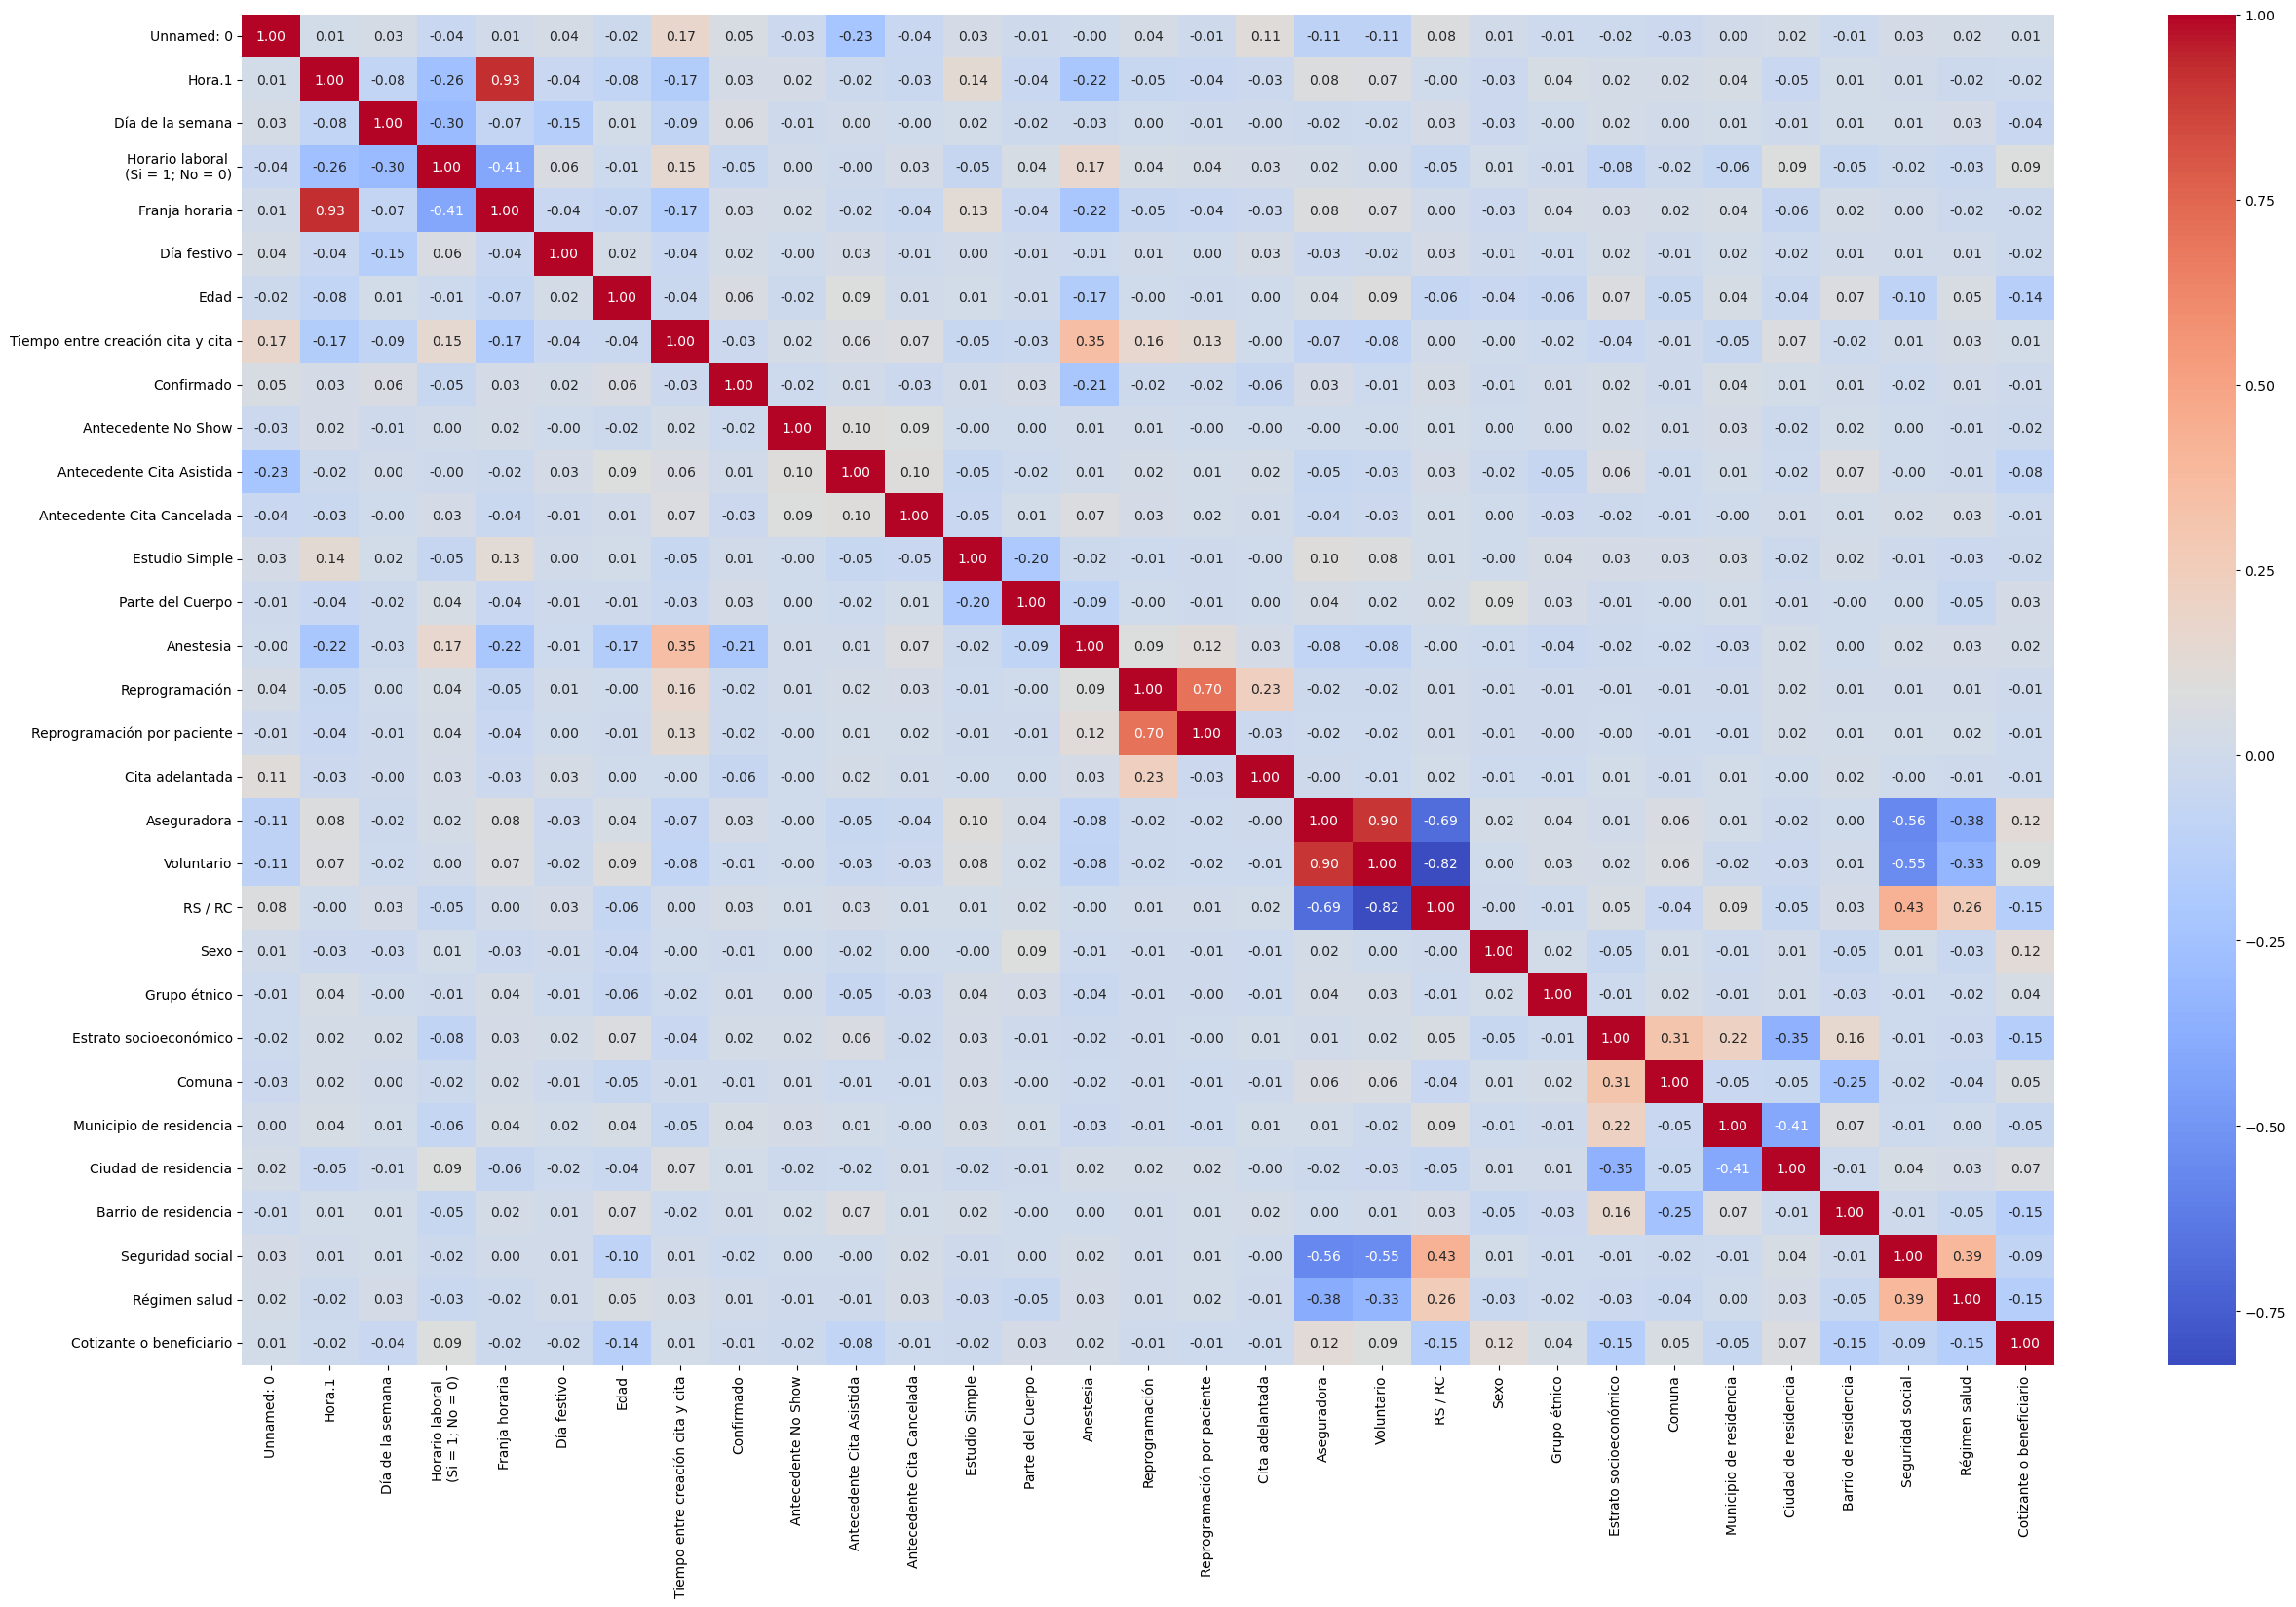

In [33]:
X = df.drop(columns=['Tipo de Cita VARIABLE OBJETIVO'])
y = df['Tipo de Cita VARIABLE OBJETIVO']

# Calculate correlation matrix
corr_matrix = X.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(30, 18))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [34]:
#Threshold for removing correlated variables
threshold = abs(0.7)
# Absolute value correlation matrix
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
#Select the colums with high threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('Hay %d columnas para remover.' % (len(to_drop)))
print(to_drop)


Hay 4 columnas para remover.
['Franja horaria', 'Reprogramación por paciente', 'Voluntario', 'RS / RC']


In [23]:
df2= df.drop(columns=['Reprogramación por paciente', 'Voluntario', 'RS / RC'])

<Figure size 1000x600 with 0 Axes>

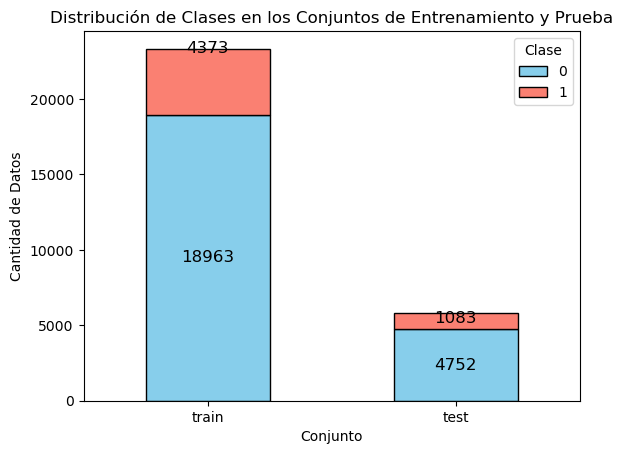

In [24]:
X = df2.drop(columns=['Tipo de Cita VARIABLE OBJETIVO'])
Y = df2['Tipo de Cita VARIABLE OBJETIVO']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 69)

train_class_counts = pd.Series(Y_train).value_counts().sort_index()
test_class_counts = pd.Series(Y_test).value_counts().sort_index()

# Crear un DataFrame para facilitar la visualización
distribution_df = pd.DataFrame({
    'train': train_class_counts,
    'test': test_class_counts
}).T

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))
distribution_df.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], edgecolor='black')

# Añadir los números en las barras
for i, col in enumerate(distribution_df.columns):
    for j, val in enumerate(distribution_df[col]):
        plt.text(x=j, y=val + distribution_df.iloc[i-1, j] if i > 0 else val/2,
                 s=f'{int(val)}', ha='center', va='center', fontsize=12, color='black')

plt.title('Distribución de Clases en los Conjuntos de Entrenamiento y Prueba')
plt.xlabel('Conjunto')
plt.ylabel('Cantidad de Datos')
plt.xticks(rotation=0)
plt.legend(title='Clase')
plt.show()

In [25]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, Y_train)

# Normalize data after applying SMOTE

scaler = MinMaxScaler(feature_range=(0, 1))
#scaler.fit(X)
X_t = scaler.fit_transform(X_resampled)
X_test= scaler.transform(X_test)

#scaler = StandardScaler()
#X_resampled_normalized = scaler.fit_transform(X_resampled)

# Verify the balance of classes
print(X_train.shape)
print(Y_train.shape)


(23336, 28)
(23336,)


<Figure size 1000x600 with 0 Axes>

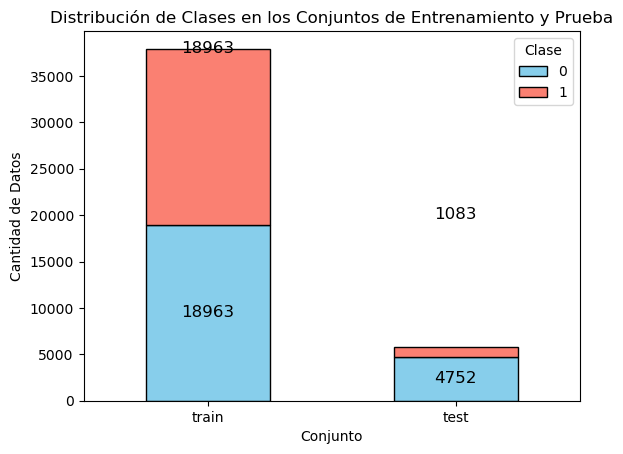

In [27]:
train_class_counts = pd.Series(y_resampled).value_counts().sort_index()
test_class_counts = pd.Series(Y_test).value_counts().sort_index()

# Crear un DataFrame para facilitar la visualización
distribution_df = pd.DataFrame({
    'train': train_class_counts,
    'test': test_class_counts
}).T

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))
distribution_df.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], edgecolor='black')

# Añadir los números en las barras
for i, col in enumerate(distribution_df.columns):
    for j, val in enumerate(distribution_df[col]):
        plt.text(x=j, y=val + distribution_df.iloc[i-1, j] if i > 0 else val/2,
                 s=f'{int(val)}', ha='center', va='center', fontsize=12, color='black')

plt.title('Distribución de Clases en los Conjuntos de Entrenamiento y Prueba')
plt.xlabel('Conjunto')
plt.ylabel('Cantidad de Datos')
plt.xticks(rotation=0)
plt.legend(title='Clase')
plt.show()

# Models training ADA-XG Boost, RF

In [28]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


# Modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_t, y_resampled)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(Y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

# Modelo XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_t, y_resampled)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(Y_test, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")

# Modelo AdaBoost
ab_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ab_model.fit(X_t, y_resampled)
ab_predictions = ab_model.predict(X_test)
ab_accuracy = accuracy_score(Y_test, ab_predictions)
print(f"AdaBoost Accuracy: {ab_accuracy:.2f}")


Random Forest Accuracy: 0.84
XGBoost Accuracy: 0.84


c:\Users\migue\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.82


'\nmodel = LogisticRegression()\nmodel.fit(X_train, y_resampled)\n# Hacer predicciones\ny_pred = model.predict(X_test)\n# Evaluar el modelo\naccuracy = accuracy_score(Y_test, y_pred)\nreport = classification_report(Y_test, y_pred)'

In [30]:
model = LogisticRegression()
model.fit(X_t, y_resampled)
# Hacer predicciones
y_pred = model.predict(X_test)
# Evaluar el modelo
accuracy = accuracy_score(Y_test, y_pred)
report = classification_report(Y_test, y_pred)

In [31]:
print(f"Precisión: {accuracy:.2f}")
print("Reporte de clasificación:")
print(report)

Precisión: 0.77
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      4752
           1       0.42      0.66      0.52      1083

    accuracy                           0.77      5835
   macro avg       0.67      0.73      0.68      5835
weighted avg       0.82      0.77      0.79      5835



In [32]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import uniform, randint
# Crear el modelo XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Definir el espacio de hiperparámetros para la búsqueda aleatoria
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 10)
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Ajustar la búsqueda aleatoria al conjunto de entrenamiento
random_search.fit(X_t, y_resampled)

# Mejor modelo encontrado
best_model = random_search.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred = best_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(Y_test, y_pred)
report = classification_report(Y_test, y_pred)

print(f"Mejores Hiperparámetros: {random_search.best_params_}")
print(f"Precisión: {accuracy:.2f}")
print("Reporte de clasificación:")
print(report)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\migue\anaconda3\envs\tf\lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores Hiperparámetros: {'colsample_bytree': 0.8059264473611898, 'gamma': 1.3949386065204183, 'learning_rate': 0.09764339456056544, 'max_depth': 9, 'n_estimators': 239, 'subsample': 0.5453032172664104}
Precisión: 0.84
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4752
           1       0.58      0.51      0.54      1083

    accuracy                           0.84      5835
   macro avg       0.74      0.71      0.72      5835
weighted avg       0.83      0.84      0.84      5835



# FINAL VERSION

- Load final_data.csv
- Run preprocessing 2.0 

In [39]:
df2= df.drop(columns=['Voluntario', 'RS / RC','Unnamed: 0'])
df2 = df2.rename(columns={'Horario laboral \n(Si = 1; No = 0)': 'Horario laboral'})
df2.head()

Hora.1  Día de la semana  Horario laboral  Franja horaria  Día festivo  \
0 -1.023239         -0.933359                1               0            0   
1  0.747842         -0.933359                1               1            0   
2  0.969227         -0.933359                1               1            0   
3 -0.359084         -0.933359                1               0            0   
4 -0.580469         -0.933359                1               0            0   

       Edad  Tiempo entre creación cita y cita  Confirmado  \
0 -2.473743                           3.031527           0   
1  0.248236                          -0.727551           0   
2 -1.688557                           0.181903           1   
3  0.352928                          -0.727551           0   
4 -1.008062                          -0.485030           0   

   Antecedente No Show  Antecedente Cita Asistida  Antecedente Cita Cancelada  \
0                    0                          0                           0   
1                    0                          0                           0   
2                    0                          0                           0   
3                    0                          0                           0   
4                    0                          0                           0   

   Estudio Simple  Anestesia  Reprogramación  Reprogramación por paciente  \
0               1          1               1                            1   
1               1          0               0                            0   
2               1          0               0                            0   
3               1          0               0                            0   
4               1          0               0                            0   

   Cita adelantada  Tipo de Cita VARIABLE OBJETIVO  Estrato socioeconómico  \
0                0                               0               -0.912449   
1                0                               0               -0.912449   
2                0                               0                1.818274   
3                0                               0               -0.912449   
4                0                               0               -0.912449   

     Comuna  Municipio de residencia  Ciudad de residencia  \
0  0.576563                 0.181781              0.185985   
1 -0.942106                 0.181781              0.192722   
2  1.420268                 0.181781              0.185985   
3  0.576563                 0.182104              0.149254   
4  0.576563                 0.181781              0.178862   

   Barrio de residencia  Seguridad social  Régimen salud  \
0              0.246930          0.236641       0.190725   
1              0.190568          0.191546       0.182858   
2              0.183333          0.206661       0.204744   
3              0.246930          0.239607       0.202771   
4              0.246930          0.120459       0.136469   

   Cotizante o beneficiario  Parte del Cuerpo_CEREBRO  \
0                  0.184475                      True   
1                  0.189728                     False   
2                  0.189728                     False   
3                  0.179413                     False   
4                  0.179413                     False   

   Parte del Cuerpo_COLUMNA  Parte del Cuerpo_CORAZON  Parte del Cuerpo_MAMA  \
0                     False                     False                  False   
1                     False                     False                  False   
2                      True                     False                  False   
3                     False                     False                  False   
4                      True                     False                  False   

   Parte del Cuerpo_MMII  Parte del Cuerpo_MMSS  Parte del Cuerpo_OTRO  \
0                  False                  False                  False   
1                   True        

<Figure size 1000x600 with 0 Axes>

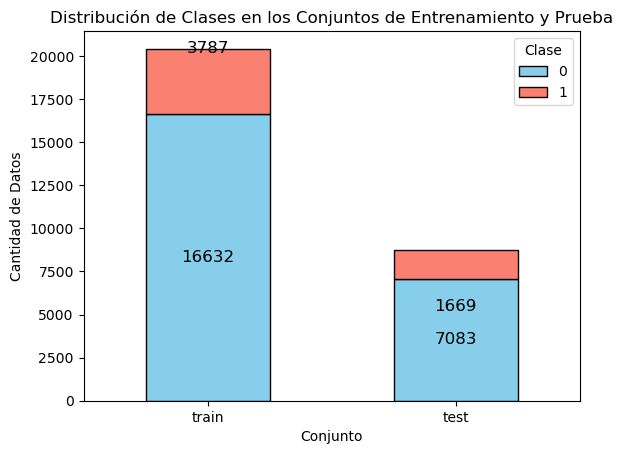

In [40]:
X = df2.drop(columns=['Tipo de Cita VARIABLE OBJETIVO'])
Y = df2['Tipo de Cita VARIABLE OBJETIVO']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 69) #0.8518, 30 % TEST-0.8552

train_class_counts = pd.Series(Y_train).value_counts().sort_index()
test_class_counts = pd.Series(Y_test).value_counts().sort_index()

# Crear un DataFrame para facilitar la visualización
distribution_df = pd.DataFrame({
    'train': train_class_counts,
    'test': test_class_counts
}).T

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))
distribution_df.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], edgecolor='black')

# Añadir los números en las barras
for i, col in enumerate(distribution_df.columns):
    for j, val in enumerate(distribution_df[col]):
        plt.text(x=j, y=val + distribution_df.iloc[i-1, j] if i > 0 else val/2,
                 s=f'{int(val)}', ha='center', va='center', fontsize=12, color='black')

plt.title('Distribución de Clases en los Conjuntos de Entrenamiento y Prueba')
plt.xlabel('Conjunto')
plt.ylabel('Cantidad de Datos')
plt.xticks(rotation=0)
plt.legend(title='Clase')
plt.show()

In [41]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, Y_train)

# Normalize data after applying SMOTE

#scaler = MinMaxScaler(feature_range=(0, 1))
#scaler.fit(X)
#X_t = scaler.fit_transform(X_resampled)
#X_test= scaler.transform(X_test)

#scaler = StandardScaler()
#X_resampled_normalized = scaler.fit_transform(X_resampled)
print(X_train.shape)
print(Y_train.shape)

(20419, 50)
(20419,)


## Logistic regression

Matriz de Confusión:
[[6854  229]
 [1170  499]]


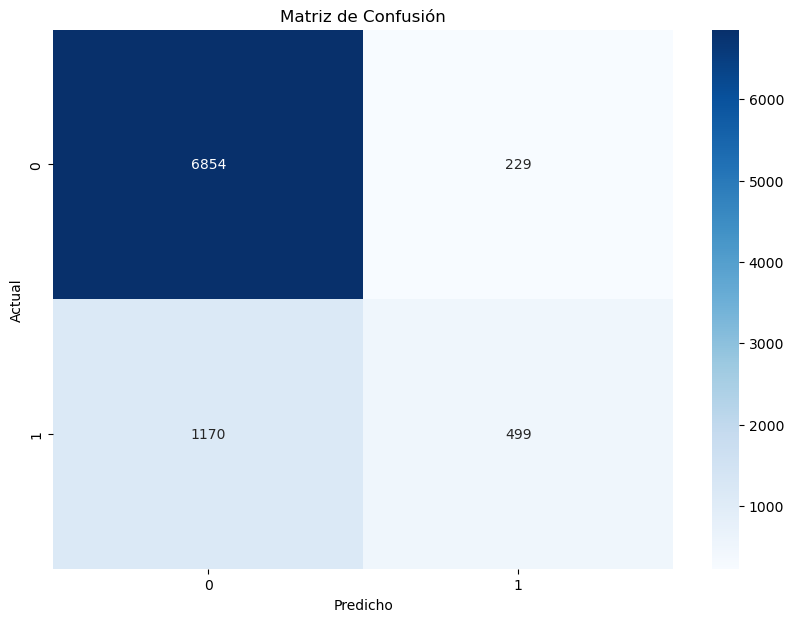

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      7083
           1       0.69      0.30      0.42      1669

    accuracy                           0.84      8752
   macro avg       0.77      0.63      0.66      8752
weighted avg       0.82      0.84      0.81      8752



In [42]:
# Entrenamiento del modelo
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, Y_train)

# Predicción con el modelo
y_pred = lr.predict(X_test)

# Generar matriz de confusión
conf_matrix = confusion_matrix(Y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Visualización de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión')
plt.show()

# Generar reporte de clasificación
class_report = classification_report(Y_test, y_pred)
print("Reporte de Clasificación:")
print(class_report)

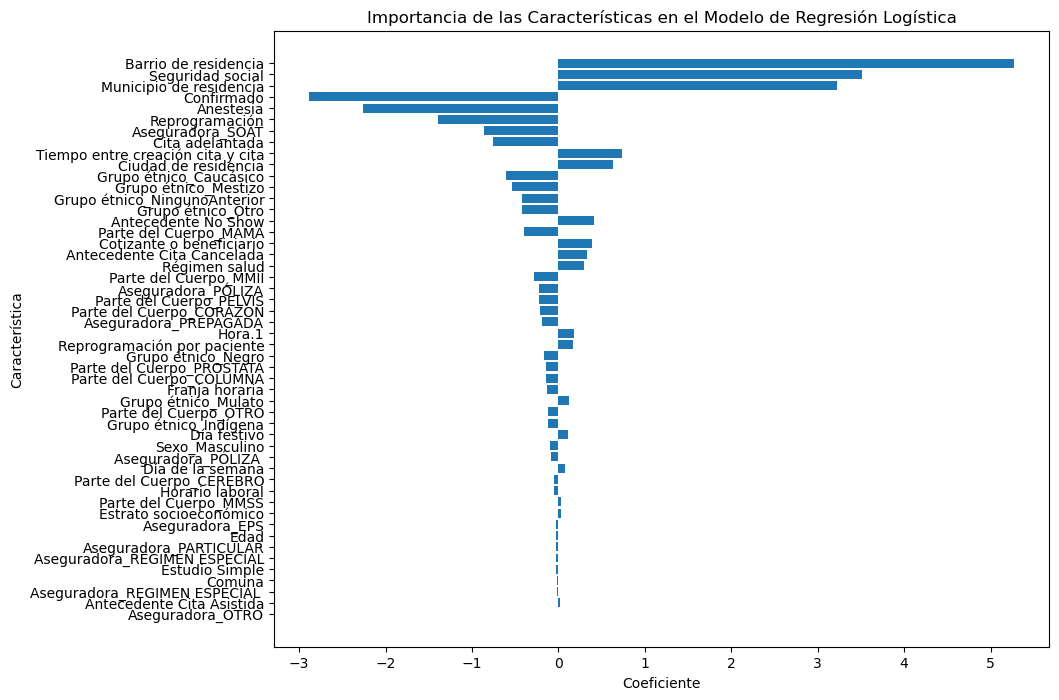

In [43]:
coefficients = lr.coef_[0]
features = X.columns

# Crear un DataFrame para los coeficientes
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Ordenar los coeficientes por su valor absoluto
coef_df['AbsCoefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Graficar los coeficientes
plt.figure(figsize=(10, 8))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coeficiente')
plt.ylabel('Característica')
plt.title('Importancia de las Características en el Modelo de Regresión Logística')
plt.gca().invert_yaxis()
plt.show()

In [44]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
import ipywidgets as widgets
from IPython.display import display

In [45]:
def calculate_metrics(threshold):
    y_proba = lr.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    accuracy = accuracy_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    class_report = classification_report(Y_test, y_pred)
    print(f"Umbral: {threshold:.2f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print( "Reporte de clasificación:")
    print(class_report )
    print("-" * 30)

# Crear slider interactivo
threshold_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.02, description='Umbral:')

# Conectar el slider a la función
widgets.interactive(calculate_metrics, threshold=threshold_slider)

interactive(children=(FloatSlider(value=0.5, description='Umbral:', max=1.0, step=0.02), Output()), _dom_class…

Conclusion: It is better to have a threshold of 0.7 since the accuracy improves

## XGBoost, RF and Lightgbm

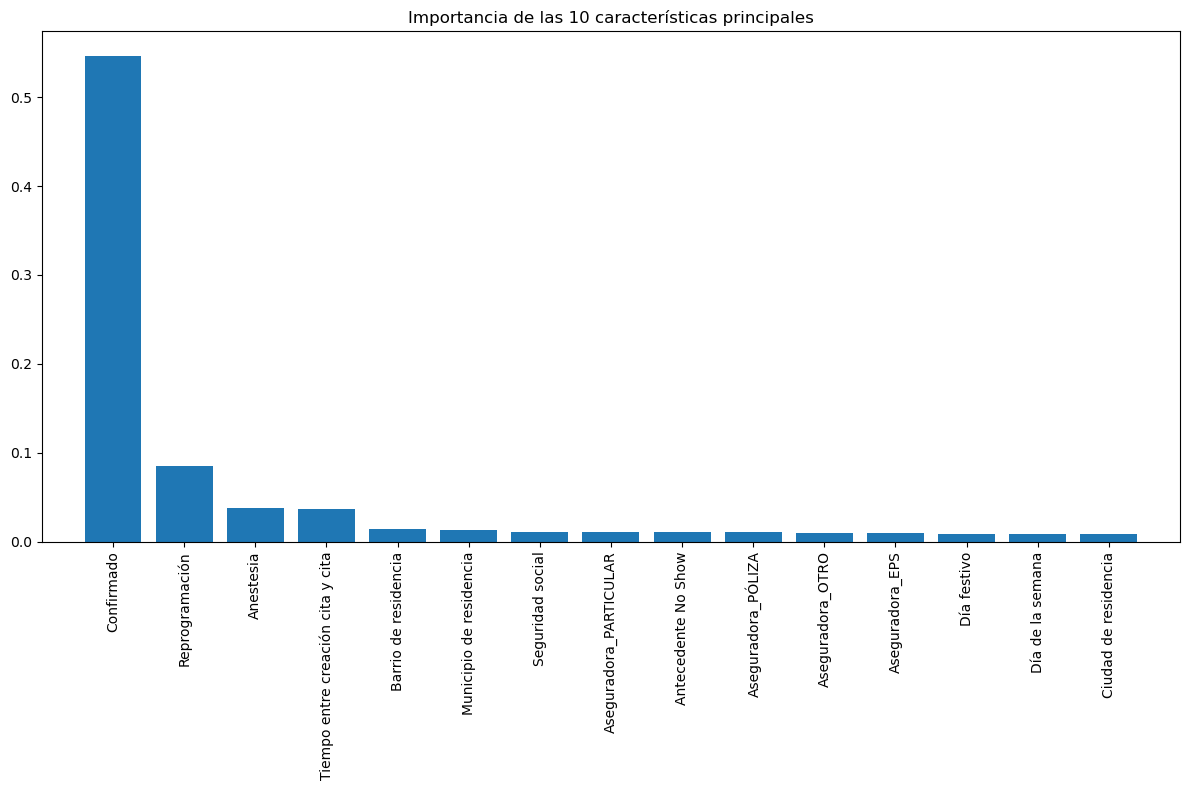

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Entrenar un modelo de Random Forest
rf = XGBClassifier(n_estimators=200, gamma= 0, learning_rate= 0.1, max_depth= 4,  random_state=69) #change the classifier to RF to check
rf.fit(X_train, Y_train)

# Obtener las importancias de las características
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Obtener los nombres de las características ordenadas por importancia
feature_names = X_resampled.columns
sorted_feature_names = [feature_names[i] for i in indices]

# Seleccionar las 10 características más importantes
top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_sorted_feature_names = [feature_names[i] for i in top_indices]

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
plt.title("Importancia de las 10 características principales")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_sorted_feature_names, rotation=90)
plt.xlim([-1, top_n])
plt.tight_layout()
plt.show()


In [51]:
xgb_predictions = rf.predict(X_test)
xgb_accuracy = accuracy_score(Y_test, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

conf_matrix = confusion_matrix(Y_test, xgb_predictions)
print("Matriz de Confusión:")
print(conf_matrix)

XGBoost Accuracy: 0.8552
Matriz de Confusión:
[[6707  376]
 [ 891  778]]


In [48]:
report = classification_report(Y_test, xgb_predictions)
print("Reporte de clasificación:")
print(report)

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      7083
           1       0.67      0.47      0.55      1669

    accuracy                           0.86      8752
   macro avg       0.78      0.71      0.73      8752
weighted avg       0.84      0.86      0.84      8752



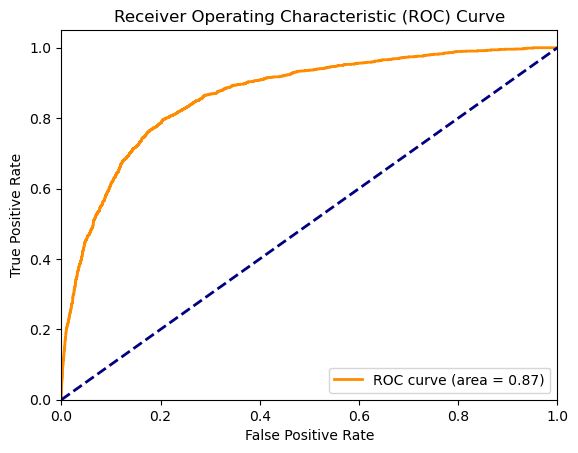

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Compute the ROC curve data
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)

# Compute the AUC (Area Under the Curve)
auc = roc_auc_score(Y_test, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [53]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [200, 100, 50],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05,  0.1,  0.15],
    'gamma': [0, 0.01, 0.05],

}

# Crear un GridSearchCV con validación cruzada de 5 folds
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Ajustar el GridSearchCV al conjunto de entrenamiento
grid_search.fit(X_train, Y_train)

# Mostrar los mejores parámetros encontrados
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

# Usar el mejor modelo para hacer predicciones en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluar el modelo
print(classification_report(Y_test, y_pred))
print("Accuracy on test set:", accuracy_score(Y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best accuracy score:  0.8579755216380572
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      7083
           1       0.68      0.47      0.55      1669

    accuracy                           0.86      8752
   macro avg       0.78      0.71      0.73      8752
weighted avg       0.84      0.86      0.85      8752

Accuracy on test set: 0.8558043875685558


Best parameters found:{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

## Undersampling

In [54]:
sat = df2[(df2['Tipo de Cita VARIABLE OBJETIVO'] == 0)]
nat = df2[(df2['Tipo de Cita VARIABLE OBJETIVO'] == 1)]

    # Ccalcular el # muestras para cada genero
samples_per_genre = 5455

    # Muestra de cada dataframe, uno para 1 y otro para 0
df_sampled_0 = sat.sample(samples_per_genre)
df_sampled_1 = nat.sample(samples_per_genre)

    # concatenar los dos df para obtener el df final balanceado
df_balanced = pd.concat([df_sampled_0, df_sampled_1])

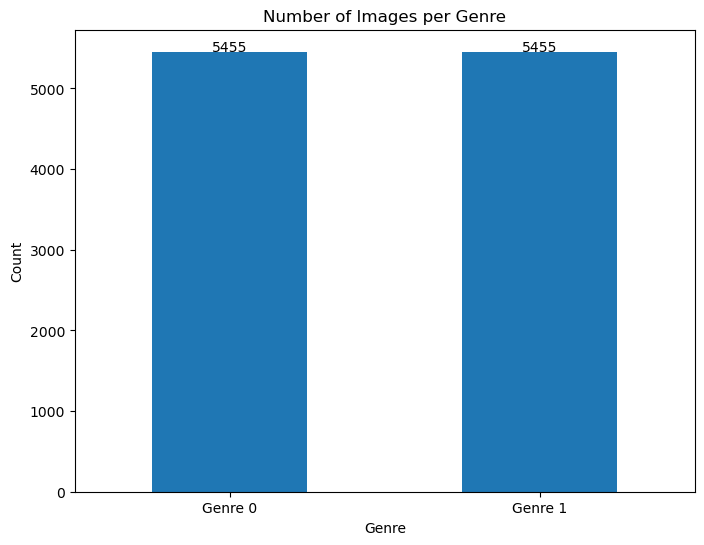

In [55]:
#Visualizamos la distribucion de los datos para los subconjuntos
genre_counts = df_balanced['Tipo de Cita VARIABLE OBJETIVO'].value_counts()

# Crear un box plot
plt.figure(figsize=(8, 6))
ax=genre_counts.plot(kind='bar')
plt.title('Number of Images per Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Genre 0', 'Genre 1'], rotation=0)

for i, v in enumerate(genre_counts):
    ax.text(i, v + 0.2, str(v), color='black', ha='center') #Mostrar  el valor numerico de cada barra

plt.show()

In [56]:
X = df_balanced.drop(columns=['Tipo de Cita VARIABLE OBJETIVO'])
Y = df_balanced['Tipo de Cita VARIABLE OBJETIVO']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(8728, 50)
(2182, 50)
(8728,)
(2182,)


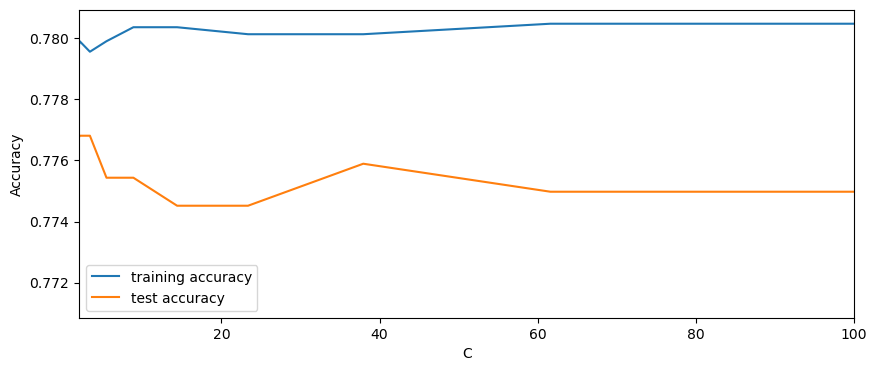

In [59]:
training_accuracy_l = []
test_accuracy_l = []
C = np.logspace(-2,2,20)
for C_p in C:
    # build the model
    clf = LogisticRegression(C=C_p,random_state=42,max_iter=1000, solver='lbfgs')
    clf.fit(X_train, Y_train)
    # record training set accuracy
    training_accuracy_l.append(clf.score(X_train, Y_train))
    # record generalization accuracy
    test_accuracy_l.append(clf.score(X_test, Y_test))
fig, axe = plt.subplots(ncols=1,figsize=(10, 4))
plt.plot(C, training_accuracy_l, label="training accuracy")
plt.plot(C, test_accuracy_l, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.xlim(2, 100)
plt.legend()
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4364, number of negative: 4364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 792
[LightGBM] [Info] Number of data points in the train set: 8728, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\migue\anaconda3\envs\tf\lib\site-packages\xgboost\core.py:158: UserWarning: [16:43:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.785518   0.781391  0.792851  0.787079
1             LightGBM  0.785060   0.785846  0.783685  0.784764
2              XGBoost  0.778185   0.778185  0.778185  0.778185
3  Logistic Regression  0.773602   0.741310  0.840513  0.787801


c:\Users\migue\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 1400x800 with 0 Axes>

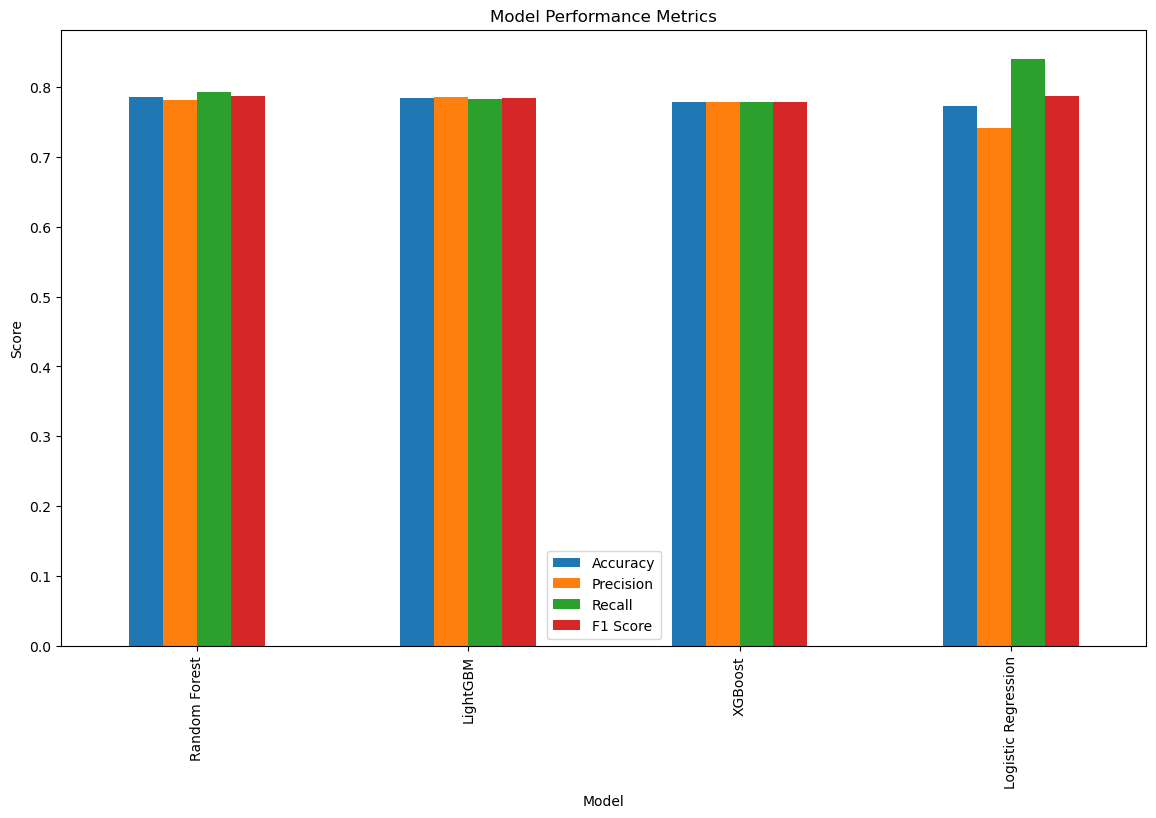

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Load your data
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(C=40, random_state=42)
}

# Training and evaluating models
metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for name, model in models.items():
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(Y_test, y_pred))
    metrics['Precision'].append(precision_score(Y_test, y_pred))
    metrics['Recall'].append(recall_score(Y_test, y_pred))
    metrics['F1 Score'].append(f1_score(Y_test, y_pred))

# Creating a DataFrame with the metrics
metrics_df = pd.DataFrame(metrics)

# Displaying the metrics DataFrame
print(metrics_df)

# Plotting the metrics
plt.figure(figsize=(14, 8))
metrics_df.set_index('Model').plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(loc='best')
plt.show()

# Unificación de las bases de datos (DEPRECATED)

In [ ]:
df.to_csv('df2.csv')

In [ ]:
final=df.drop(columns=['Codigo aseguradora', 'Fecha de nacimiento', 'Fecha', 'Hora','Agente Cita','Fecha crea. cita'])
final.info()

In [ ]:
mode_Sexo = df['Sexo'].mode()[0]
df['Sexo'].fillna(mode_Sexo, inplace=True)

In [ ]:
final=df

In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29171 entries, 0 to 29170
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Fecha                              29171 non-null  datetime64[ns]
 1   Hora                               29171 non-null  object        
 2   Hora.1                             29171 non-null  int64         
 3   Día de la semana                   29171 non-null  int64         
 4   Horario laboral 
(Si = 1; No = 0)  29171 non-null  int64         
 5   Franja horaria                     29171 non-null  int64         
 6   Día festivo                        29171 non-null  int64         
 7   Num Dcto Modif                     29171 non-null  int64         
 8   Edad                               29171 non-null  float64       
 9   Fecha crea. cita                   29171 non-null  datetime64[ns]
 10  Tiempo entre creación cita y cita 

# USING UNDERSAMPLING PRIMITIVE VERSION

In [26]:
    # Dividir el df en dos en función del genero
sat = final[(final['Tipo de Cita VARIABLE OBJETIVO'] == 0)]
nat = final[(final['Tipo de Cita VARIABLE OBJETIVO'] == 1)]

    # Ccalcular el # muestras para cada genero
samples_per_genre = 5455

    # Muestra de cada dataframe, uno para 1 y otro para 0
df_sampled_0 = sat.sample(samples_per_genre)
df_sampled_1 = nat.sample(samples_per_genre)

    # concatenar los dos df para obtener el df final balanceado
df_balanced = pd.concat([df_sampled_0, df_sampled_1])

NameError: name 'final' is not defined

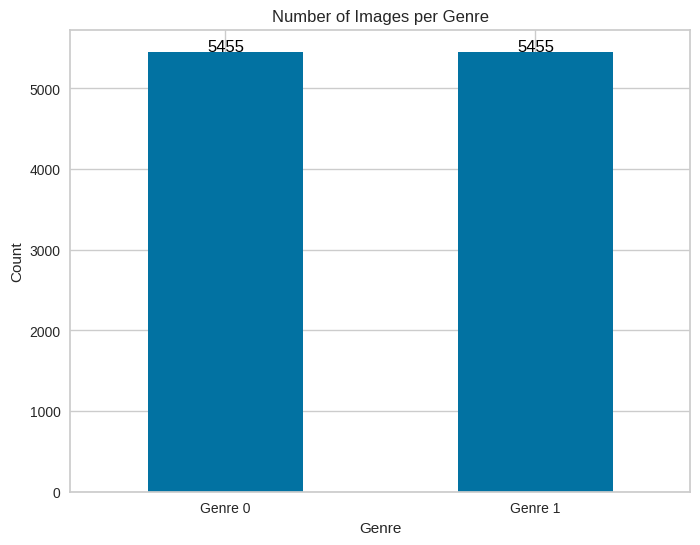

In [ ]:
#Visualizamos la distribucion de los datos para los subconjuntos
genre_counts = df_balanced['Tipo de Cita VARIABLE OBJETIVO'].value_counts()

# Crear un box plot
plt.figure(figsize=(8, 6))
ax=genre_counts.plot(kind='bar')
plt.title('Number of Images per Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Genre 0', 'Genre 1'], rotation=0)

for i, v in enumerate(genre_counts):
    ax.text(i, v + 0.2, str(v), color='black', ha='center') #Mostrar  el valor numerico de cada barra

plt.show()


## Lectura Dataset




In [ ]:
# Reading data
data_df = df_balanced
#data_df = final
print(data_df.shape)
data_df.head()

(10910, 42)


Fecha      Hora  Hora.1  Día de la semana  \
21489 2019-08-20  19:00:00      19                 1   
16983 2019-03-27  19:35:00      19                 2   
1644  2018-09-17  06:10:00       6                 0   
1500  2019-03-09  17:50:00      17                 5   
24138 2019-11-18  12:00:00      12                 0   

       Horario laboral \n(Si = 1; No = 0)  Franja horaria  Día festivo  \
21489                                   0               2            0   
16983                                   0               2            0   
1644                                    0               0            0   
1500                                    0               1            0   
24138                                   1               1            0   

       Num Dcto Modif       Edad Fecha crea. cita  ...  Grupo étnico  \
21489           15260  56.797260       2019-08-05  ...             7   
16983           11708  50.013699       2019-03-22  ...             7   
1644             1016  13.410959       2018-08-27  ...             7   
1500              915  57.838356       2019-03-04  ...             7   
24138           17428  37.115068       2019-10-22  ...             7   

      Estrato socioeconómico  Comuna  Municipio de residencia  \
21489                    5.0     2.0                       30   
16983                    5.0    19.0                       30   
1644                     2.0    15.0                       30   
1500                     5.0     2.0                       30   
24138                    2.0    17.0                       30   

       Ciudad de residencia  Barrio de residencia  Codigo aseguradora  \
21489                    28                   201          1000000268   
16983                    28                   126          1000000164   
1644                     28                   129          1000000228   
1500                     28                   201          1000000290   
24138                   116                    61          1000000266   

       Seguridad social  Régimen salud  Cotizante o beneficiario  
21489               193             16                         0  
16983                29              4                         0  
1644                 41              7                         8  
1500                 48             16                        12  
24138               199              7                         4  

[5 rows x 42 columns]

In [ ]:
datos=data_df

#Exploración de Variables (EDA)

##Verificación de variables no nulas

In [ ]:
datos.info()
total = datos.isnull().sum().sort_values(ascending=False)
percent_1 = datos.isnull().sum()/datos.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(datos.size)

<class 'pandas.core.frame.DataFrame'>
Index: 10910 entries, 21489 to 10345
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Fecha                              10910 non-null  datetime64[ns]
 1   Hora                               10910 non-null  object        
 2   Hora.1                             10910 non-null  int64         
 3   Día de la semana                   10910 non-null  int64         
 4   Horario laboral 
(Si = 1; No = 0)  10910 non-null  int64         
 5   Franja horaria                     10910 non-null  int64         
 6   Día festivo                        10910 non-null  int64         
 7   Num Dcto Modif                     10910 non-null  int64         
 8   Edad                               10910 non-null  float64       
 9   Fecha crea. cita                   10910 non-null  datetime64[ns]
 10  Tiempo entre creación cita y cita  

Total    %
Codigo aseguradora                    162  1.5
Fecha de nacimiento                    10  0.1
Fecha                                   0  0.0
Sexo                                    0  0.0
Reprogramación                          0  0.0
Reprogramación por paciente             0  0.0
Cita adelantada                         0  0.0
Aseguradora                             0  0.0
Voluntario                              0  0.0
RS / RC                                 0  0.0
Tipo de Cita VARIABLE OBJETIVO          0  0.0
Grupo étnico                            0  0.0
Hora                                    0  0.0
Estrato socioeconómico                  0  0.0
Comuna                                  0  0.0
Municipio de residencia                 0  0.0
Ciudad de residencia                    0  0.0
Barrio de residencia                    0  0.0
Seguridad social                        0  0.0
Régimen salud                           0  0.0
Anestesia                               0  0.0
Parte del Cuerpo                        0  0.0
Estudio Simple                          0  0.0
Antecedente Cita Cancelada              0  0.0
Hora.1                                  0  0.0
Día de la semana                        0  0.0
Horario laboral \n(Si = 1; No = 0)      0  0.0
Franja horaria                          0  0.0
Día festivo                             0  0.0
Num Dcto Modif                          0  0.0
Edad                                    0  0.0
Fecha crea. cita                        0  0.0
Tiempo entre creación cita y cita       0  0.0
Agente Cita                             0  0.0
Confirmado por email                    0  0.0
Paciente NO ubicado                     0  0.0
Confirmado FAMILIAR                     0  0.0
Confirmado PACIENTE                     0  0.0
Confirmado                              0  0.0
Antecedente No Show                     0  0.0
Antecedente Cita Asistida               0  0.0
Cotizante o beneficiario                0  0.0

In [ ]:
datos = datos.dropna()

In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10748 entries, 21489 to 10345
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Fecha                              10748 non-null  datetime64[ns]
 1   Hora                               10748 non-null  object        
 2   Hora.1                             10748 non-null  int64         
 3   Día de la semana                   10748 non-null  int64         
 4   Horario laboral 
(Si = 1; No = 0)  10748 non-null  int64         
 5   Franja horaria                     10748 non-null  int64         
 6   Día festivo                        10748 non-null  int64         
 7   Num Dcto Modif                     10748 non-null  int64         
 8   Edad                               10748 non-null  float64       
 9   Fecha crea. cita                   10748 non-null  datetime64[ns]
 10  Tiempo entre creación cita y cita  

## Mapa de Calor: Correlación (variables numéricas)

In [ ]:
datosnum=datos._get_numeric_data()

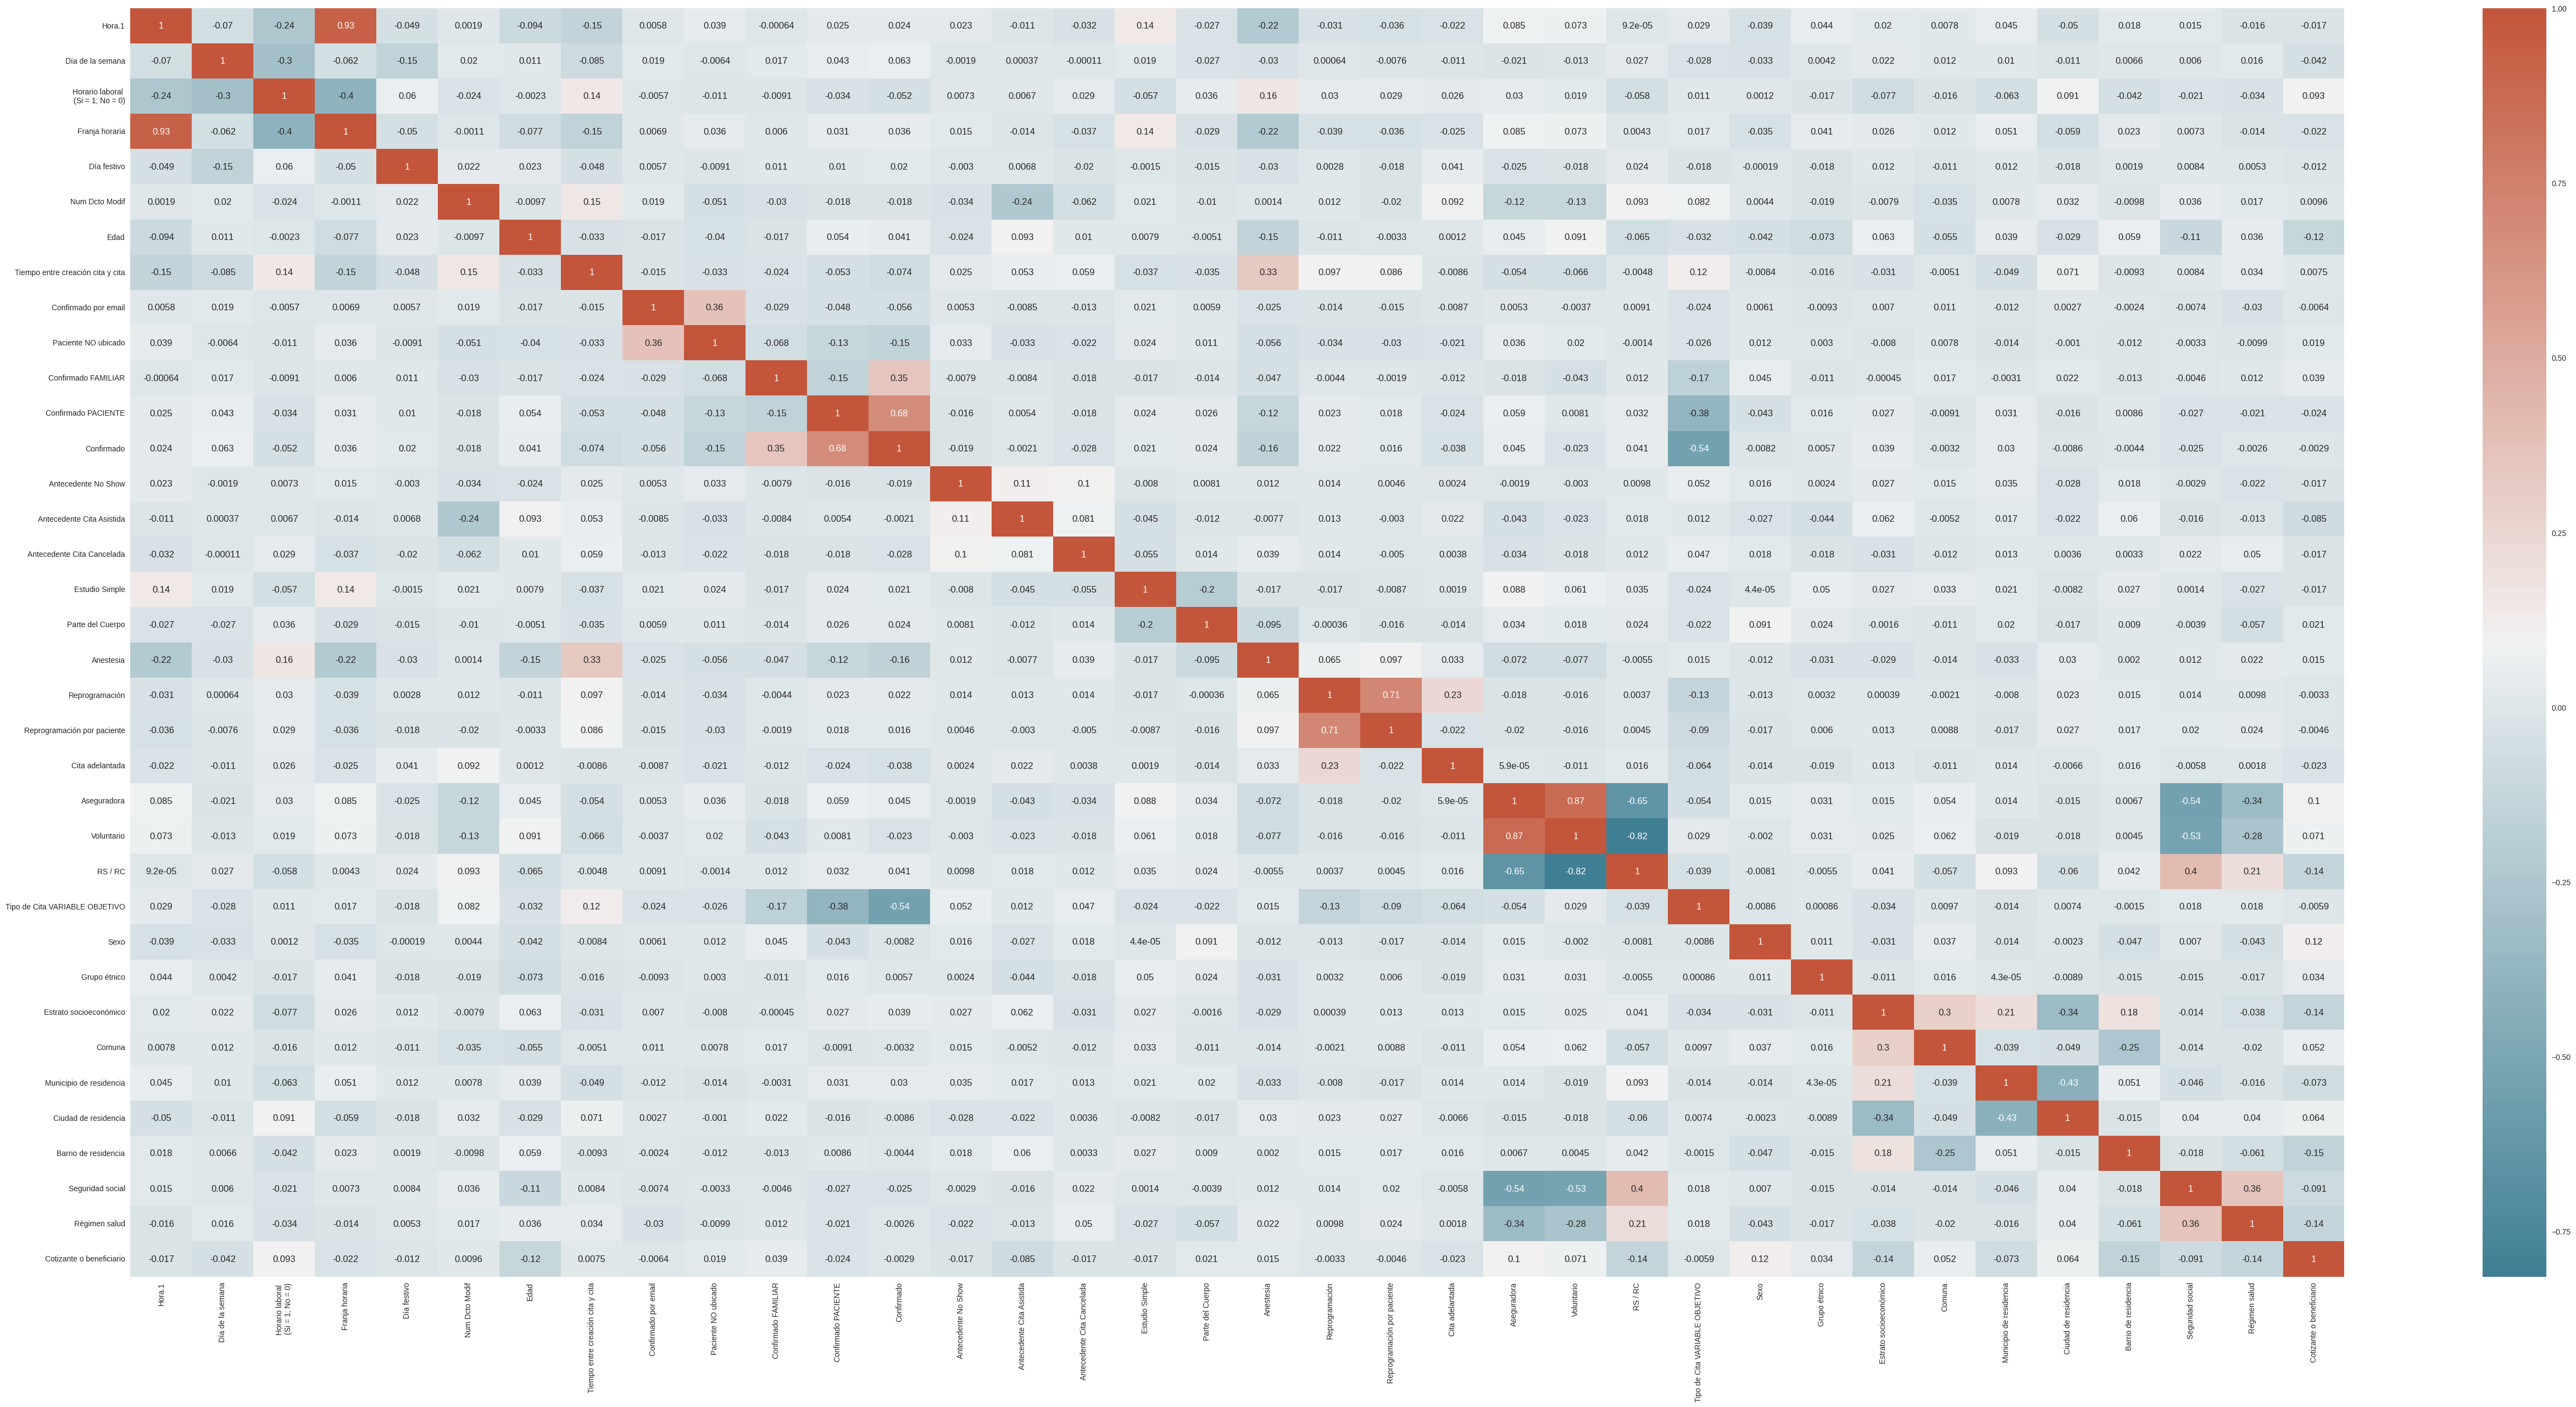

In [ ]:
corr = datosnum.corr()
plt.subplots(figsize=(65,30))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.show()

In [ ]:
datosnum.describe()

Hora.1  Día de la semana  Horario laboral \n(Si = 1; No = 0)  \
count  10748.000000      10748.000000                        10748.000000   
mean      12.600484          2.697897                            0.633885   
std        4.511087          1.839520                            0.481764   
min        6.000000          0.000000                            0.000000   
25%        9.000000          1.000000                            0.000000   
50%       13.000000          3.000000                            1.000000   
75%       16.000000          4.000000                            1.000000   
max       23.000000          6.000000                            1.000000   

       Franja horaria   Día festivo  Num Dcto Modif          Edad  \
count    10748.000000  10748.000000    10748.000000  10748.000000   
mean         0.736788      0.026796    10651.628582     49.069944   
std          0.725480      0.161493     6361.612325     19.245831   
min          0.000000      0.000000        2.000000      0.323288   
25%          0.000000      0.000000     4995.250000     35.683562   
50%          1.000000      0.000000    10537.000000     51.193151   
75%          1.000000      0.000000    16243.250000     63.233562   
max          2.000000      1.000000    21791.000000     98.558904   

       Tiempo entre creación cita y cita  Confirmado por email  \
count                       10748.000000          10748.000000   
mean                           13.775679              0.010421   
std                            21.510374              0.101553   
min                           -65.000000              0.000000   
25%                             4.000000              0.000000   
50%                             9.000000              0.000000   
75%                            17.000000              0.000000   
max                          1309.000000              1.000000   

       Paciente NO ubicado  ...          Sexo  Grupo étnico  \
count         10748.000000  ...  10748.000000  10748.000000   
mean              0.057964  ...      0.434592      6.812709   
std               0.233687  ...      0.495726      0.885560   
min               0.000000  ...      0.000000      0.000000   
25%               0.000000  ...      0.000000      7.000000   
50%               0.000000  ...      0.000000      7.000000   
75%               0.000000  ...      1.000000      7.000000   
max               1.000000  ...      1.000000      7.000000   

       Estrato socioeconómico        Comuna  Municipio de residencia  \
count            10748.000000  10748.000000              10748.00000   
mean                 3.318943     13.580666                 28.83048   
std                  1.470743      5.936993                  4.27897   
min                  1.000000      1.000000                  0.00000   
25%                  2.000000      8.000000                 30.00000   
50%                  3.000000     17.000000                 30.00000   
75%                  5.000000     17.000000                 30.00000   
max                  6.000000     22.000000                 30.00000   

       Ciudad de residencia  Barrio de residencia  Seguridad social  \
count          10748.000000          10748.000000      10748.000000   
mean              46.884723            209.699851        119.725996   
std               40.293203            128.527442         65.333757   
min                0.000000              3.000000          0.000000   
25%               28.000000             69.000000         62.000000   
50%               28.000000            206.000000        140.000000   
75%               31.000000            295.000000        182.000000   
max              197.000000            447.000000        216.000000   

       Régimen salud  Cotizante o beneficiario  
count   10748.000000              10748.000000  
mean        6.471437                  4.420729  
std         5.357597                  5.278698  
min         0.000000                  0.000000  


## Distribución de las Clases en el dataset

Rows, Columns: (10748, 42)
Tipo de Cita VARIABLE OBJETIVO
0    5451
1    5297
dtype: int64 [0 1] [5451 5297]


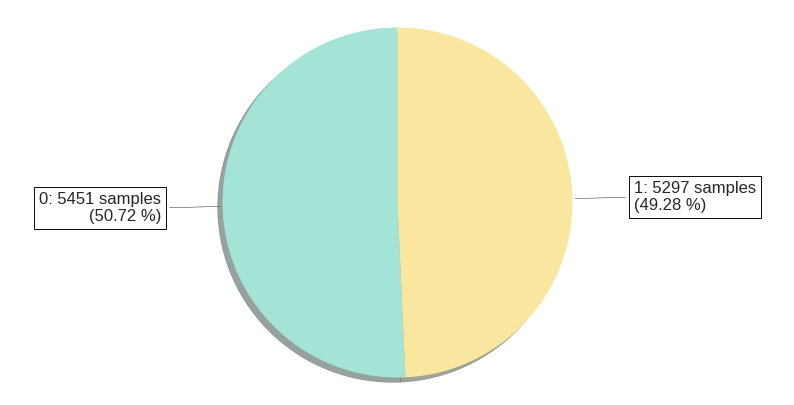

In [ ]:
print("Rows, Columns:",datos.shape)
Clases = datos.groupby('Tipo de Cita VARIABLE OBJETIVO').size()
labels = Clases.index.values
sizes = Clases.values
print(Clases,labels,sizes)
muestra = []

for k in range(0,labels.size):
  texto = str(labels[k])+': '+str(sizes[k])+' samples\n({:,.2f} %)'.format((100*sizes[k]/sum(sizes)))
  muestra.append(texto)

colors = ['#A3E4D7','#F9E79F','#D5DBDB','#E6B0AA','#D7BDE2','#A9CCE3','#AEB6BF','#EDBB99','#5DADE2','#F4D03F','#27AE60','#A569BD','#C0392B','#138D75']
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
fig,ax1 = plt.subplots(figsize=(10,5),ncols=1,nrows=1)
wedges, texts = ax1.pie(sizes, shadow=True, colors=colors, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax1.annotate(muestra[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
# Separar variables independientes y etiquetas
X = datos.drop(['Tipo de Cita VARIABLE OBJETIVO'], axis=1)
y = datos['Tipo de Cita VARIABLE OBJETIVO']

# Sobremuestrear la clase minoritaria
oversampler = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversampler.fit_resample(X, y)

# Crear un nuevo DataFrame con las variables independientes y etiquetas sobremuestreadas
datos_over = pd.concat([pd.DataFrame(X_over), pd.DataFrame(y_over, columns=['Tipo de Cita VARIABLE OBJETIVO'])], axis=1)

# Verificar que las clases estén balanceadas
print(datos_over['Tipo de Cita VARIABLE OBJETIVO'].value_counts())

Tipo de Cita VARIABLE OBJETIVO
0    5451
1    5451
Name: count, dtype: int64


#Preprocesamiento de Datos

###Definición de las caracteristicas (X) y la variable a estimar (Y)

In [ ]:
X = datos_over.drop(['Tipo de Cita VARIABLE OBJETIVO'], axis=1) #En el dataframe X quitamos la variable de respuesta "Label"
print(X.shape)

(10902, 41)


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10902 entries, 0 to 10901
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Fecha                              10902 non-null  datetime64[ns]
 1   Hora                               10902 non-null  object        
 2   Hora.1                             10902 non-null  int64         
 3   Día de la semana                   10902 non-null  int64         
 4   Horario laboral 
(Si = 1; No = 0)  10902 non-null  int64         
 5   Franja horaria                     10902 non-null  int64         
 6   Día festivo                        10902 non-null  int64         
 7   Num Dcto Modif                     10902 non-null  int64         
 8   Edad                               10902 non-null  float64       
 9   Fecha crea. cita                   10902 non-null  datetime64[ns]
 10  Tiempo entre creación cita y cita 

In [ ]:
# prompt: elimina los datetime64 y los object de X

# Seleccionar columnas que no sean de tipo datetime64[ns] ni object
X = X.select_dtypes(exclude=['datetime64[ns]', 'object'])
print(X.shape)
X.info()


(10902, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10902 entries, 0 to 10901
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Hora.1                             10902 non-null  int64  
 1   Día de la semana                   10902 non-null  int64  
 2   Horario laboral 
(Si = 1; No = 0)  10902 non-null  int64  
 3   Franja horaria                     10902 non-null  int64  
 4   Día festivo                        10902 non-null  int64  
 5   Num Dcto Modif                     10902 non-null  int64  
 6   Edad                               10902 non-null  float64
 7   Tiempo entre creación cita y cita  10902 non-null  int64  
 8   Confirmado por email               10902 non-null  int64  
 9   Paciente NO ubicado                10902 non-null  int64  
 10  Confirmado FAMILIAR                10902 non-null  int64  
 11  Confirmado PACIENTE                10902 n

In [ ]:
le = LabelEncoder()
Y = datos_over['Tipo de Cita VARIABLE OBJETIVO'].values.astype(str)
Y = le.fit_transform(Y)
print(Y.shape)
print("------------------------")
print(type(Y)) #Es un array
print("------------------------")
print(Y)

(10902,)
------------------------
<class 'numpy.ndarray'>
------------------------
[0 0 0 ... 1 1 1]


###Eliminación de Valores faltantes


In [ ]:
missing = (X.isnull().sum() / len(X)).sort_values(ascending = False)
missing = missing.index[missing > 0.7]
all_missing = list(set(missing))
print('Hay %d columnas con mas del 70%% de los datos vacios' % len(all_missing))

Hay 0 columnas con mas del 70% de los datos vacios


### Remover caracteristicas con varianza cero


In [ ]:
from sklearn.feature_selection import VarianceThreshold
v_thres = VarianceThreshold(threshold=0)
v_thres.fit(X)
Cols = X.columns[v_thres.get_support()]
X = v_thres.transform(X)
X = pd.DataFrame(X,columns=Cols)
X.shape

(10902, 35)

###Identificar y eliminar colinealidades (alta correlacion)

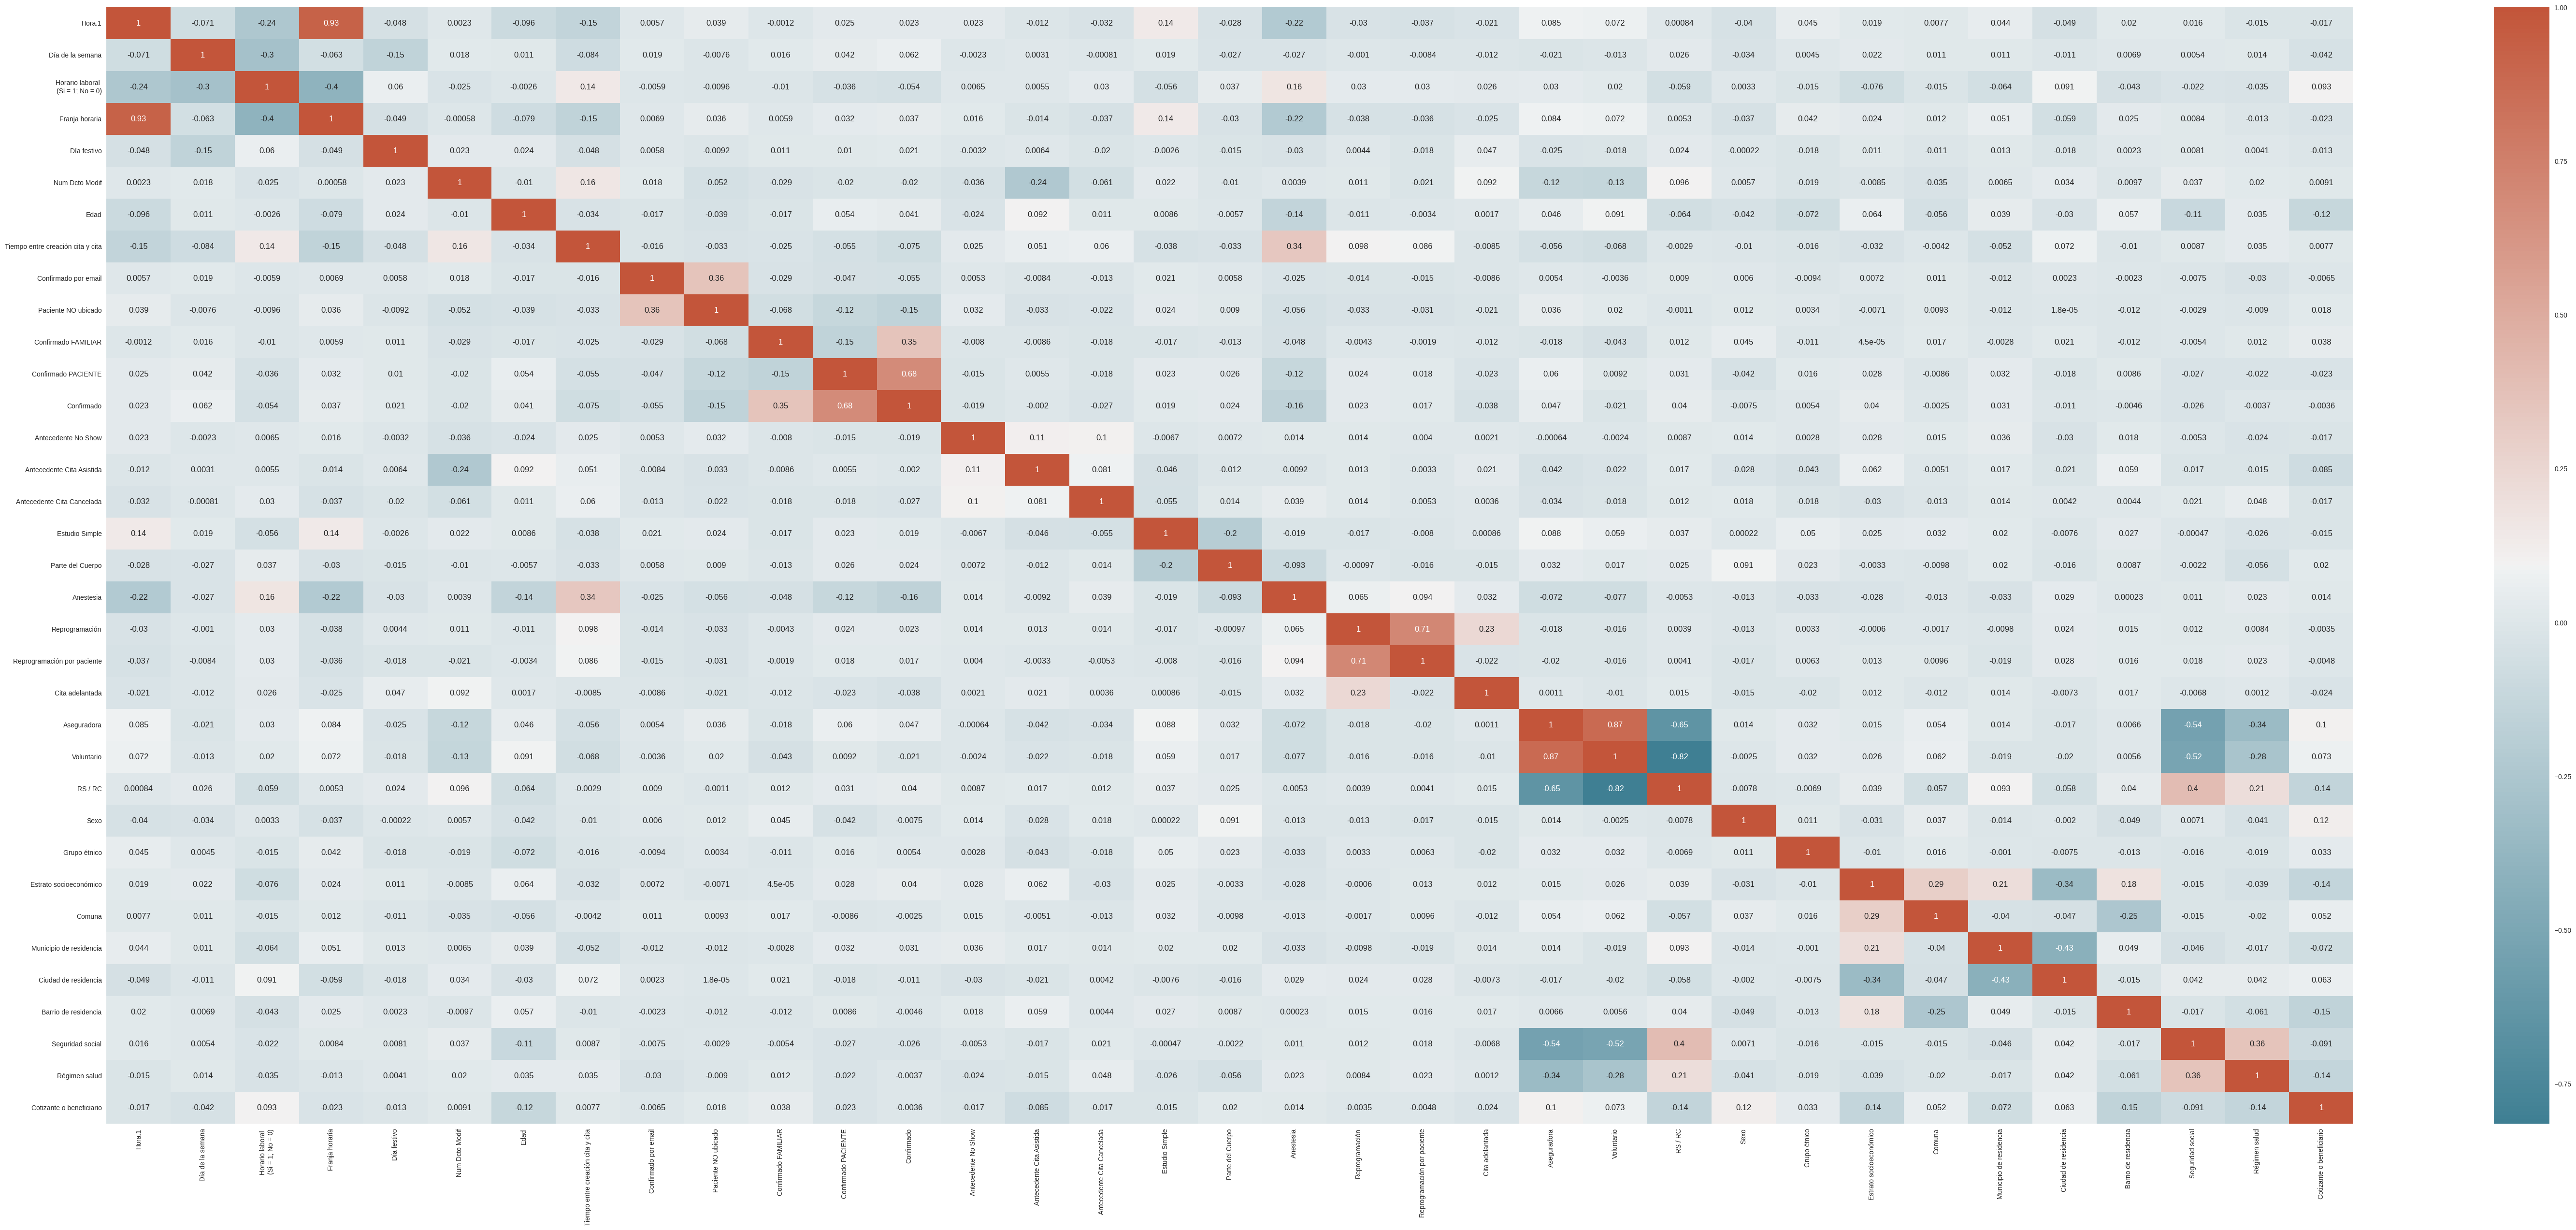

In [ ]:
corr = X.corr()
plt.subplots(figsize=(75,30))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.show()

In [ ]:
#Threshold for removing correlated variables
threshold = abs(0.7)
# Absolute value correlation matrix
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
#Select the colums with high threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('Hay %d columnas para remover.' % (len(to_drop)))
print(to_drop)


Hay 4 columnas para remover.
['Franja horaria', 'Reprogramación por paciente', 'Voluntario', 'RS / RC']


In [ ]:
X = X.drop(to_drop, axis=1)
print(X.shape)

(10902, 31)


In [ ]:
view = X.columns
print(view)

Index(['Hora.1', 'Día de la semana', 'Horario laboral \n(Si = 1; No = 0)',
       'Día festivo', 'Num Dcto Modif', 'Edad',
       'Tiempo entre creación cita y cita', 'Confirmado por email',
       'Paciente NO ubicado', 'Confirmado FAMILIAR', 'Confirmado PACIENTE',
       'Confirmado', 'Antecedente No Show', 'Antecedente Cita Asistida',
       'Antecedente Cita Cancelada', 'Estudio Simple', 'Parte del Cuerpo',
       'Anestesia', 'Reprogramación', 'Cita adelantada', 'Aseguradora', 'Sexo',
       'Grupo étnico', 'Estrato socioeconómico', 'Comuna',
       'Municipio de residencia', 'Ciudad de residencia',
       'Barrio de residencia', 'Seguridad social', 'Régimen salud',
       'Cotizante o beneficiario'],
      dtype='object')


In [ ]:
X = X.drop(['Num Dcto Modif', 'Confirmado PACIENTE',  'Grupo étnico'], axis=1)
view = X.columns
print(X.shape)


(10902, 28)


In [ ]:
Y_df= pd.DataFrame(Y, columns=['Tipo de Cita VARIABLE OBJETIVO'])

In [ ]:
concat_df = pd.concat([X, Y_df], axis=1)

In [ ]:
Y_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10902 entries, 0 to 10901
Data columns (total 1 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Tipo de Cita VARIABLE OBJETIVO  10902 non-null  int64
dtypes: int64(1)
memory usage: 85.3 KB


In [ ]:
#sns.pairplot(concat_df,hue='Tipo de Cita VARIABLE OBJETIVO',height=1.5)
#plt.show()

##Normalización

In [ ]:
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(X)
X_n = scaler1.transform(X)
X_n = np.array(X_n)

##División del Dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_n, Y, test_size = 0.2, stratify=Y, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(8721, 28)
(2181, 28)
(8721,)
(2181,)


#Métodos

##Método 1:  Percerptrón (Monocapa)

### Selección de Hiperparámetros

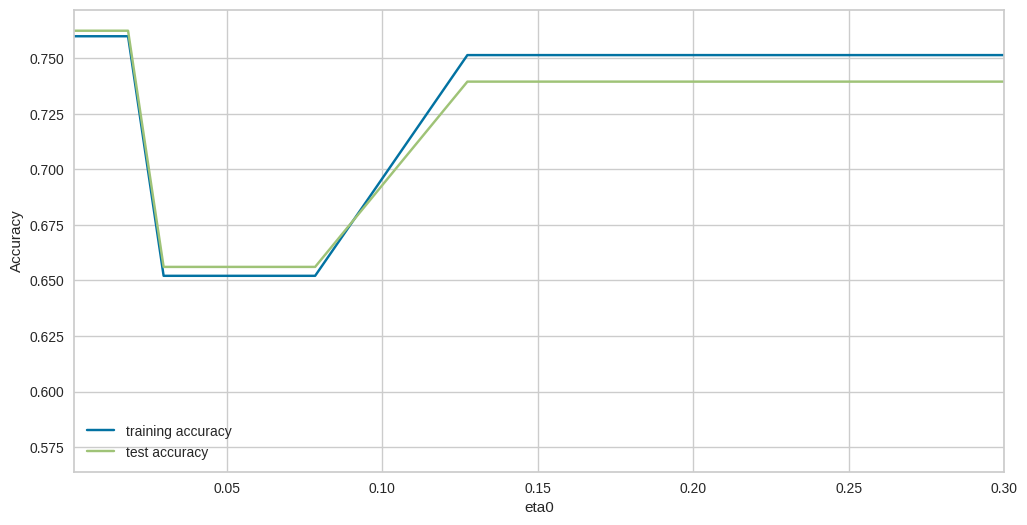

In [ ]:
training_accuracy = []
test_accuracy = []
eta0 = np.logspace(-3,1,20)
for eta in eta0:
    clf = Perceptron(max_iter=100, eta0=eta, random_state=42)
    clf.fit(X_train, Y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, Y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, Y_test))
fig, axe = plt.subplots(ncols=1,figsize=(12, 6))
plt.plot(eta0, training_accuracy, label="training accuracy")
plt.plot(eta0, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("eta0")
plt.xlim(0.001, 0.3)
plt.legend()
plt.show()

###Crear y Entrenar el perceptrón

In [ ]:
clf_per = Perceptron(max_iter=100, eta0=0.015, random_state=42)
clf_per.fit(X_train,Y_train.ravel())

Perceptron(eta0=0.015, max_iter=100, random_state=42)

### Prueba con datos de entrenamiento

Accuracy: 0.7600


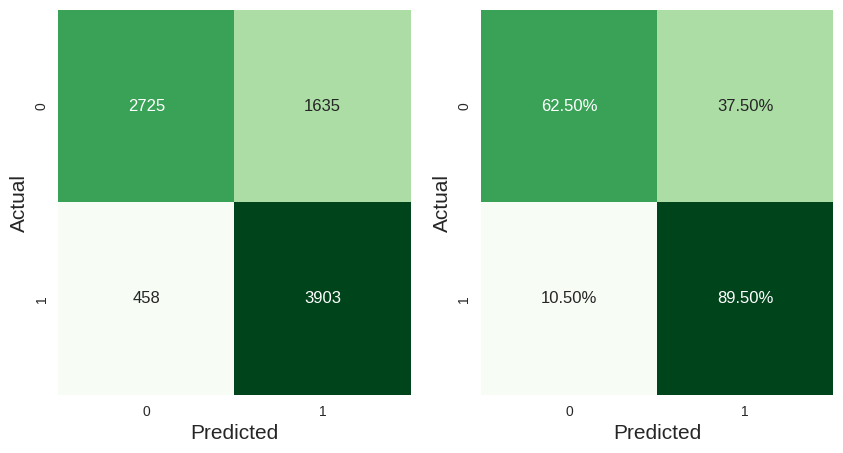

In [ ]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2,nrows=1)
y_pred_per = clf_per.predict(X_train)
print('Accuracy: %.4f' % accuracy_score(Y_train, y_pred_per))
sns.heatmap(confusion_matrix(Y_train, y_pred_per), fmt=".0f",
            annot=True, xticklabels=labels, yticklabels=labels,
            ax=ax[0], cbar=False, cmap="Greens")
sns.heatmap(confusion_matrix(Y_train, y_pred_per, normalize='true'), fmt=".2%",
            annot=True, xticklabels=labels, yticklabels=labels,
            ax=ax[1], cbar=False, cmap="Greens")
ax[0].set_xlabel('Predicted', fontsize = 15)
ax[0].set_ylabel('Actual', fontsize = 15)
ax[1].set_xlabel('Predicted', fontsize = 15)
ax[1].set_ylabel('Actual', fontsize = 15)
fig.show()

### Prueba con datos de validación

Accuracy: 0.7625


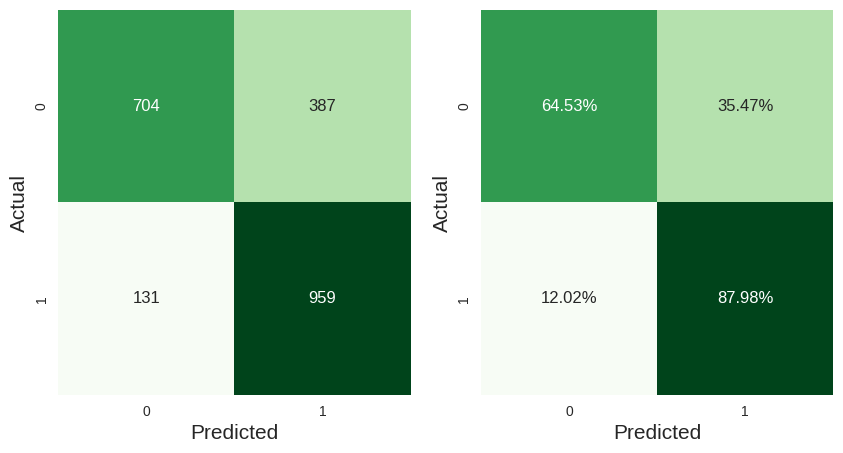

In [ ]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2,nrows=1)
y_pred_per = clf_per.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(Y_test, y_pred_per))
sns.heatmap(confusion_matrix(Y_test, y_pred_per), fmt=".0f",
            xticklabels=labels, yticklabels=labels, annot=True,
            ax=ax[0], cbar=False, cmap="Greens")
sns.heatmap(confusion_matrix(Y_test, y_pred_per, normalize='true'), fmt=".2%",
            annot=True, xticklabels=labels, yticklabels=labels,
            ax=ax[1], cbar=False, cmap="Greens")
ax[0].set_xlabel('Predicted', fontsize = 15)
ax[0].set_ylabel('Actual', fontsize = 15)
ax[1].set_xlabel('Predicted', fontsize = 15)
ax[1].set_ylabel('Actual', fontsize = 15)
fig.show()

## Método 2: Arboles de decisión

### Selección de Hiperparámetros

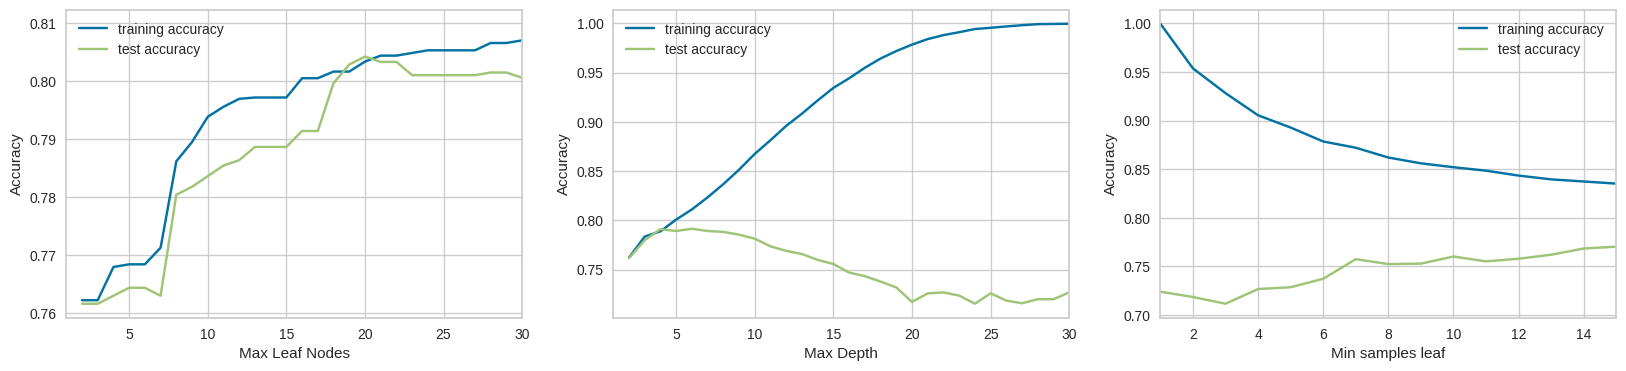

In [ ]:
training_accuracy_l1 = []
test_accuracy_l1 = []
max_leaf_nodes = range(2, 35, 1)
for leaf_nodes in max_leaf_nodes:
    # build the model
    clf = DecisionTreeClassifier(max_leaf_nodes=leaf_nodes, random_state=42)
    clf.fit(X_train, Y_train)
    # record training set accuracy
    training_accuracy_l1.append(clf.score(X_train, Y_train))
    # record generalization accuracy
    test_accuracy_l1.append(clf.score(X_test, Y_test))
training_accuracy_l2 = []
test_accuracy_l2 = []
max_depth = range(2, 31, 1)
for depth in max_depth:
    # build the model
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, Y_train)
    # record training set accuracy
    training_accuracy_l2.append(clf.score(X_train, Y_train))
    # record generalization accuracy
    test_accuracy_l2.append(clf.score(X_test, Y_test))
training_accuracy_l3 = []
test_accuracy_l3 = []
min_samples_leaf = range(1, 20, 1)
for samples_leaf in min_samples_leaf:
    # build the model
    clf = DecisionTreeClassifier(min_samples_leaf=samples_leaf,random_state=42)
    clf.fit(X_train, Y_train)
    # record training set accuracy
    training_accuracy_l3.append(clf.score(X_train, Y_train))
    # record generalization accuracy
    test_accuracy_l3.append(clf.score(X_test, Y_test))
fig, axe = plt.subplots(ncols=3,figsize=(20, 4))
plt.subplot(1,3,1)
plt.plot(max_leaf_nodes, training_accuracy_l1, label="training accuracy")
plt.plot(max_leaf_nodes, test_accuracy_l1, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Max Leaf Nodes")
plt.xlim(1, 30)
plt.legend()
plt.subplot(1,3,2)
plt.plot(max_depth, training_accuracy_l2, label="training accuracy")
plt.plot(max_depth, test_accuracy_l2, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xlim(1, 30)
plt.legend()
plt.subplot(1,3,3)
plt.plot(min_samples_leaf, training_accuracy_l3, label="training accuracy")
plt.plot(min_samples_leaf, test_accuracy_l3, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Min samples leaf")
plt.xlim(1, 15)
plt.legend()
plt.show()

###Crear y Entrenar el Arbol de Decisión

In [ ]:
clf_DT =DecisionTreeClassifier(random_state=42,max_depth = 5)
clf_DT.fit(X_train,Y_train.ravel())

DecisionTreeClassifier(max_depth=5, random_state=42)

###Análisis del arbol de Decisión

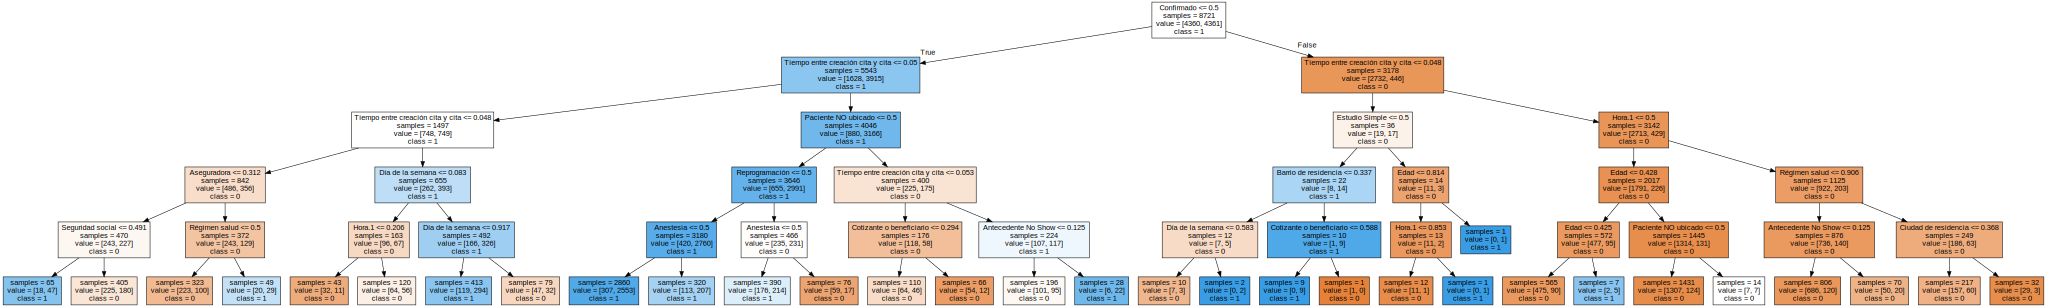

In [ ]:
import graphviz
from sklearn.tree import export_graphviz
export_graphviz(clf_DT, out_file = "arbol.dot", class_names=["0","1"],
                feature_names = view, impurity=False, filled=True)
with open("arbol.dot") as f:
  dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [ ]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

### Feature Importance

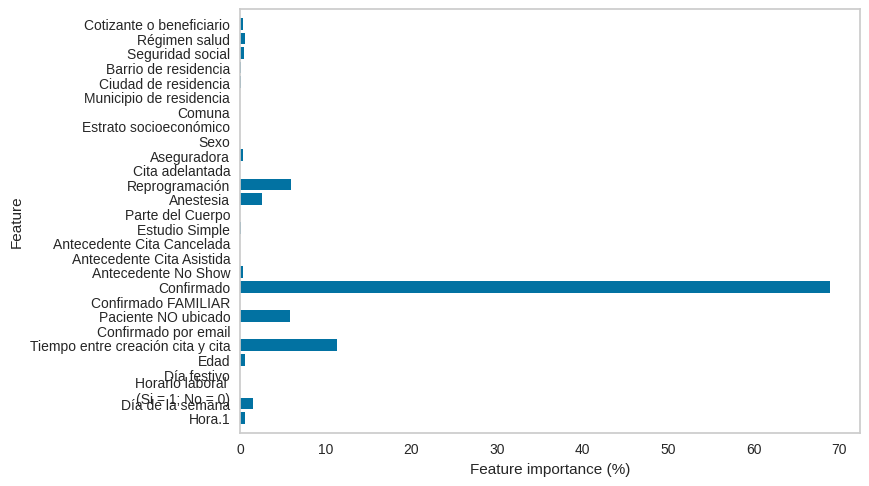

In [ ]:
n_features = view.shape[0]
plt.barh(range(n_features),clf_DT.feature_importances_*100, align='center')
plt.yticks(np.arange(n_features), view)
plt.xlabel("Feature importance (%)")
plt.ylabel("Feature")
plt.grid("")
plt.ylim(-1,n_features)
plt.show()

### Prueba con datos de entrenamiento

Accuracy: 0.80


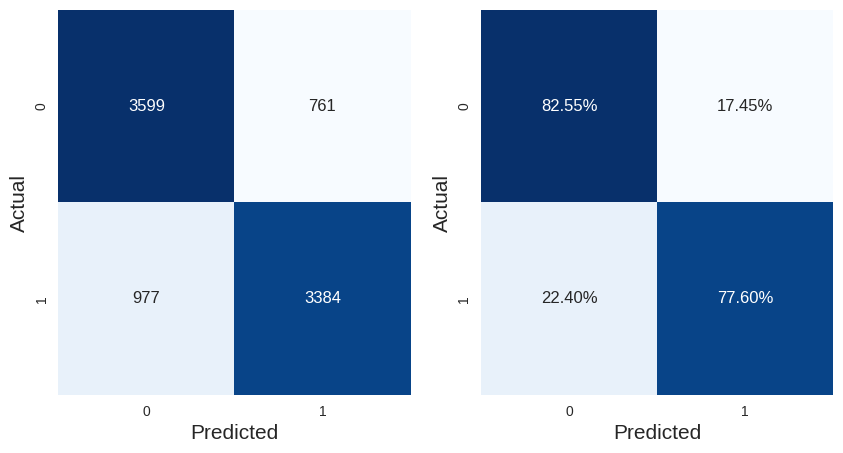

In [ ]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2,nrows=1)
y_pred_DT = clf_DT.predict(X_train)
print('Accuracy: %.2f' % accuracy_score(Y_train, y_pred_DT))
sns.heatmap(confusion_matrix(Y_train, y_pred_DT), fmt=".0f",
            annot=True, ax=ax[0], xticklabels=labels, yticklabels=labels,
            cbar=False, cmap="Blues");
sns.heatmap(confusion_matrix(Y_train, y_pred_DT, normalize='true'), fmt=".2%",
            annot=True, ax=ax[1], xticklabels=labels, yticklabels=labels,
            cbar=False, cmap="Blues");
ax[0].set_xlabel('Predicted', fontsize = 15)
ax[0].set_ylabel('Actual', fontsize = 15)
ax[1].set_xlabel('Predicted', fontsize = 15)
ax[1].set_ylabel('Actual', fontsize = 15)
fig.show()

### Prueba con datos de validación

Accuracy: 0.7891


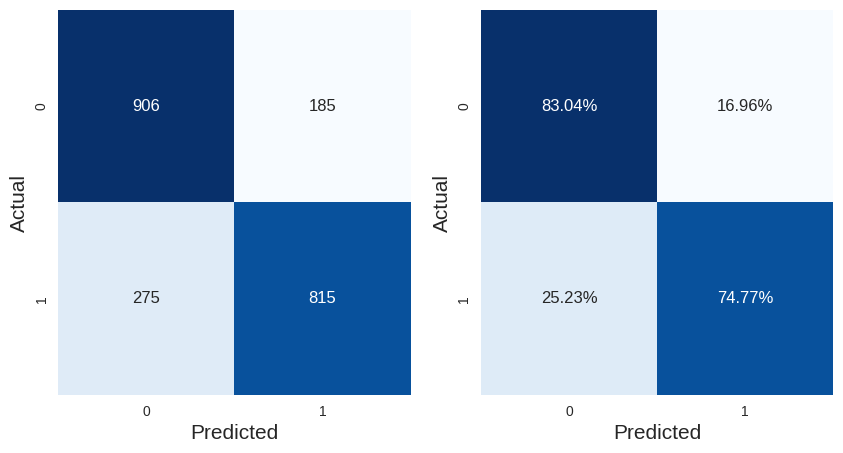

In [ ]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2,nrows=1)
y_pred_DT = clf_DT.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(Y_test, y_pred_DT))
sns.heatmap(confusion_matrix(Y_test, y_pred_DT), fmt=".0f",
            annot=True, ax=ax[0],xticklabels=labels, yticklabels=labels,
            cbar=False, cmap="Blues");
sns.heatmap(confusion_matrix(Y_test, y_pred_DT, normalize='true'), fmt=".2%",
            annot=True, ax=ax[1],xticklabels=labels, yticklabels=labels,
            cbar=False, cmap="Blues");
ax[0].set_xlabel('Predicted', fontsize = 15)
ax[0].set_ylabel('Actual', fontsize = 15)
ax[1].set_xlabel('Predicted', fontsize = 15)
ax[1].set_ylabel('Actual', fontsize = 15)
fig.show()

## Método 3: Regresión Logística

### Selección de Hiperparámetros

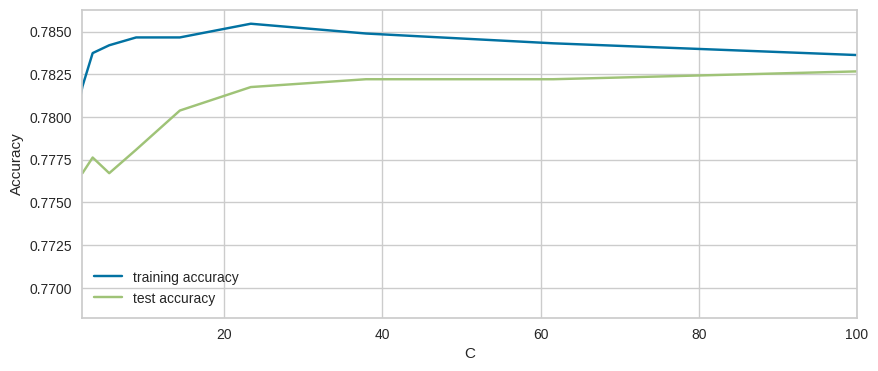

In [ ]:
training_accuracy_l = []
test_accuracy_l = []
C = np.logspace(-2,2,20)
for C_p in C:
    # build the model
    clf = LogisticRegression(C=C_p,random_state=42, solver='newton-cg')
    clf.fit(X_train, Y_train)
    # record training set accuracy
    training_accuracy_l.append(clf.score(X_train, Y_train))
    # record generalization accuracy
    test_accuracy_l.append(clf.score(X_test, Y_test))
fig, axe = plt.subplots(ncols=1,figsize=(10, 4))
plt.plot(C, training_accuracy_l, label="training accuracy")
plt.plot(C, test_accuracy_l, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.xlim(2, 100)
plt.legend()
plt.show()

### Crear y entrenar la regresión logística

In [ ]:
clf_log = LogisticRegression(C=100, solver='newton-cg', random_state=42)
clf_log.fit(X_train, Y_train.ravel())

LogisticRegression(C=100, random_state=42, solver='newton-cg')

### Prueba con datos de entrenamiento

Accuracy: 0.7836


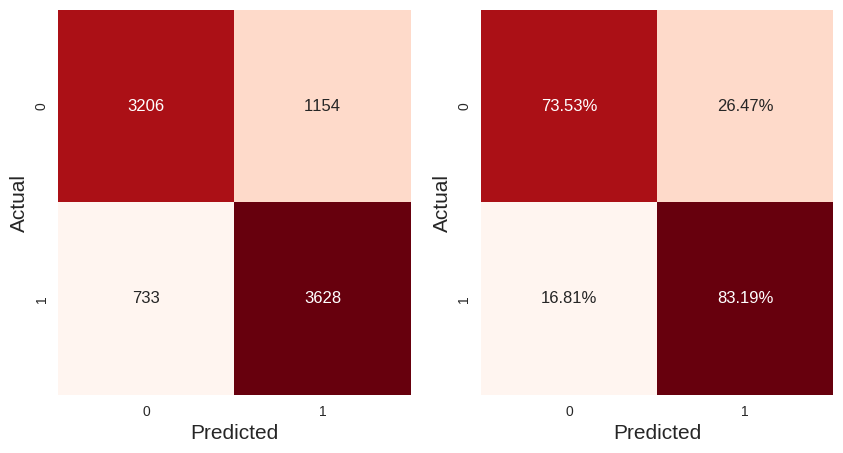

In [ ]:
# Apply the trained perceptron on the X data to make predicts for the y test data
y_pred_log = clf_log.predict(X_train)
print('Accuracy: %.4f' % accuracy_score(Y_train, y_pred_log))
fig, ax = plt.subplots(figsize=(10,5),ncols=2,nrows=1)
sns.heatmap(confusion_matrix(Y_train, y_pred_log), fmt=".0f",
            annot=True, ax=ax[0], xticklabels=labels, yticklabels=labels,
            cbar=False, cmap="Reds");
sns.heatmap(confusion_matrix(Y_train, y_pred_log, normalize='true'), fmt=".2%",
            annot=True, ax=ax[1], xticklabels=labels, yticklabels=labels,
            cbar=False, cmap="Reds");
ax[0].set_xlabel('Predicted', fontsize = 15)
ax[0].set_ylabel('Actual', fontsize = 15)
ax[1].set_xlabel('Predicted', fontsize = 15)
ax[1].set_ylabel('Actual', fontsize = 15)
fig.show()

###Prueba con datos de validación

Accuracy: 0.7827


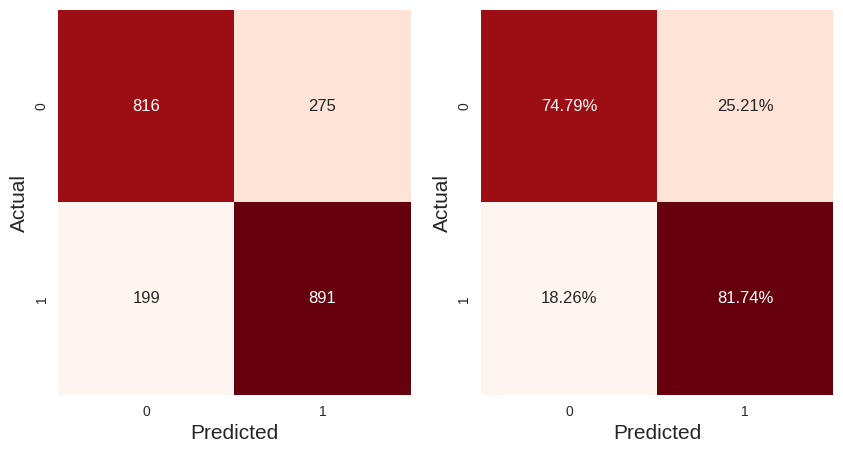

In [ ]:
y_pred_log = clf_log.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(Y_test, y_pred_log))
fig, ax = plt.subplots(figsize=(10,5),ncols=2,nrows=1)
sns.heatmap(confusion_matrix(Y_test, y_pred_log), fmt=".0f",
            annot=True, ax=ax[0], xticklabels=labels, yticklabels=labels,
            cbar=False, cmap="Reds")
sns.heatmap(confusion_matrix(Y_test, y_pred_log, normalize='true'), fmt=".2%",
            annot=True, ax=ax[1], xticklabels=labels, yticklabels=labels,
            cbar=False, cmap="Reds")
ax[0].set_xlabel('Predicted', fontsize = 15)
ax[0].set_ylabel('Actual', fontsize = 15)
ax[1].set_xlabel('Predicted', fontsize = 15)
ax[1].set_ylabel('Actual', fontsize = 15)
fig.show()

## Algunas Visualizaciones de métricas

In [ ]:
# Specify the target classes
classes = list(Clases.index)
# select classifiers
classifiers=[clf_per, clf_DT, clf_log]

## Classification Report

### Datos de entrenamiento

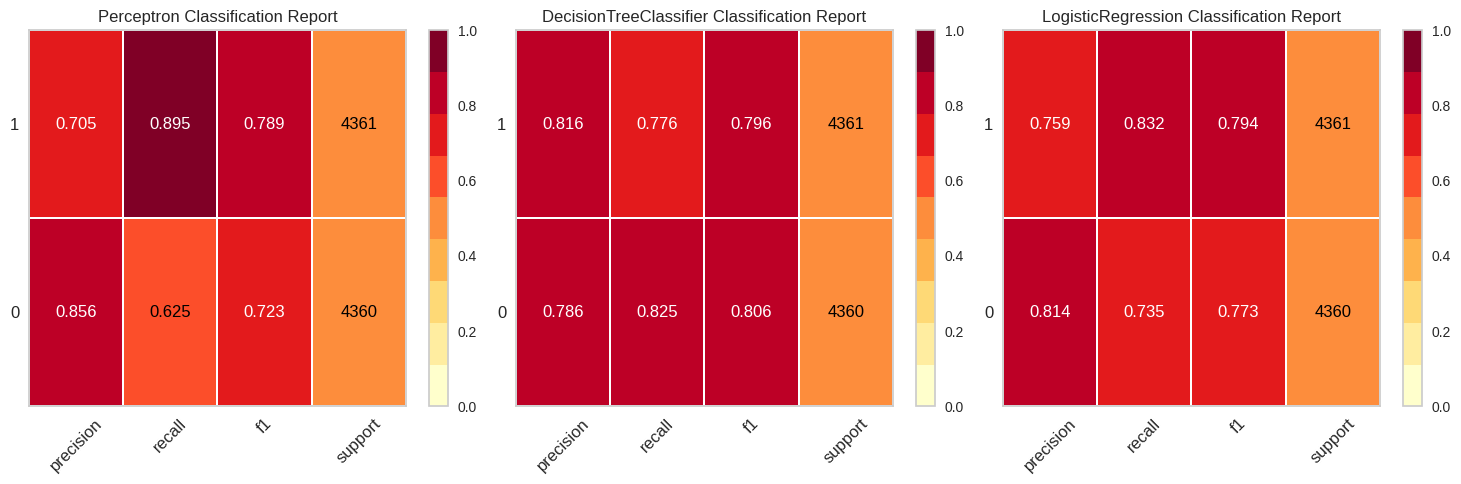

In [ ]:
fig, axe = plt.subplots(ncols=3,nrows=1,figsize=(15, 5))
fig.tight_layout(pad=8.0)
visualgrid = [ClassificationReport(classifiers[0], classes=classes, support=True, force_model=True, ax=axe[0]),
              ClassificationReport(classifiers[1], classes=classes, support=True,ax=axe[1]),
              ClassificationReport(classifiers[2], classes=classes, support=True,ax=axe[2])]
for viz in visualgrid:
  viz.fit(X_train, Y_train)
  viz.score(X_train, Y_train)
  viz.finalize()
fig.show()

### Datos de prueba

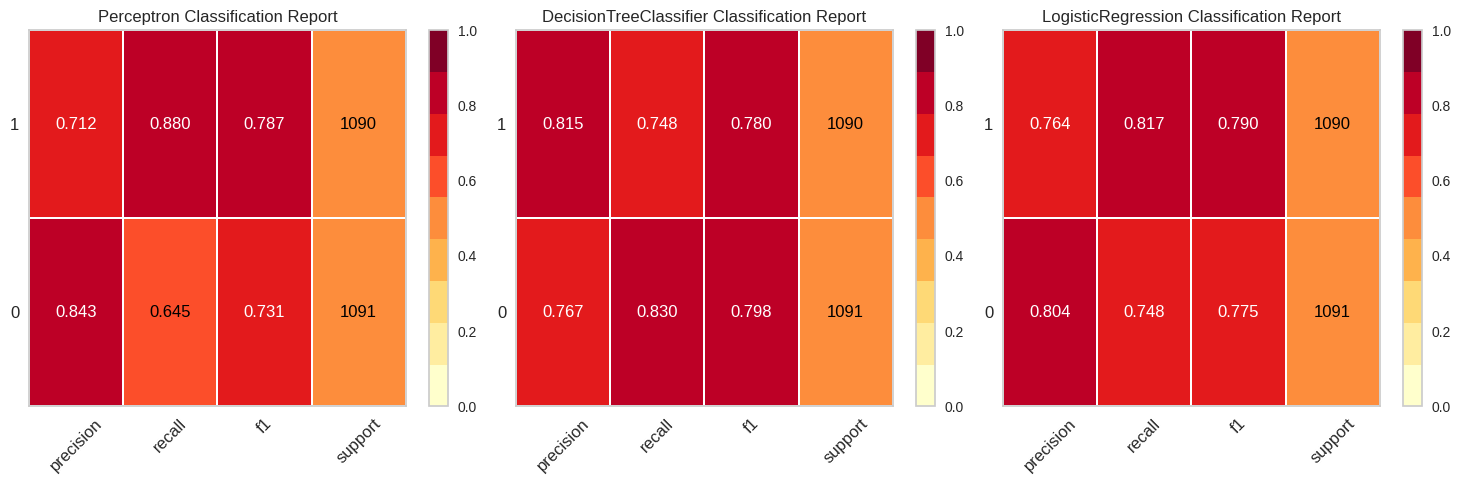

In [ ]:
#@title
fig, axe = plt.subplots(ncols=3,nrows=1,figsize=(15, 5))
fig.tight_layout(pad=8.0)
visualgrid = [ClassificationReport(classifiers[0], classes=classes, support=True,ax=axe[0]),
              ClassificationReport(classifiers[1], classes=classes, support=True,ax=axe[1]),
              ClassificationReport(classifiers[2], classes=classes, support=True,ax=axe[2])]
counter1 = 0
for viz in visualgrid:
  viz.fit(X_train, Y_train)
  viz.score(X_test, Y_test)
  viz.finalize()
fig.show()

## Class Prediction Error (CPE)

### Datos de entrenamiento

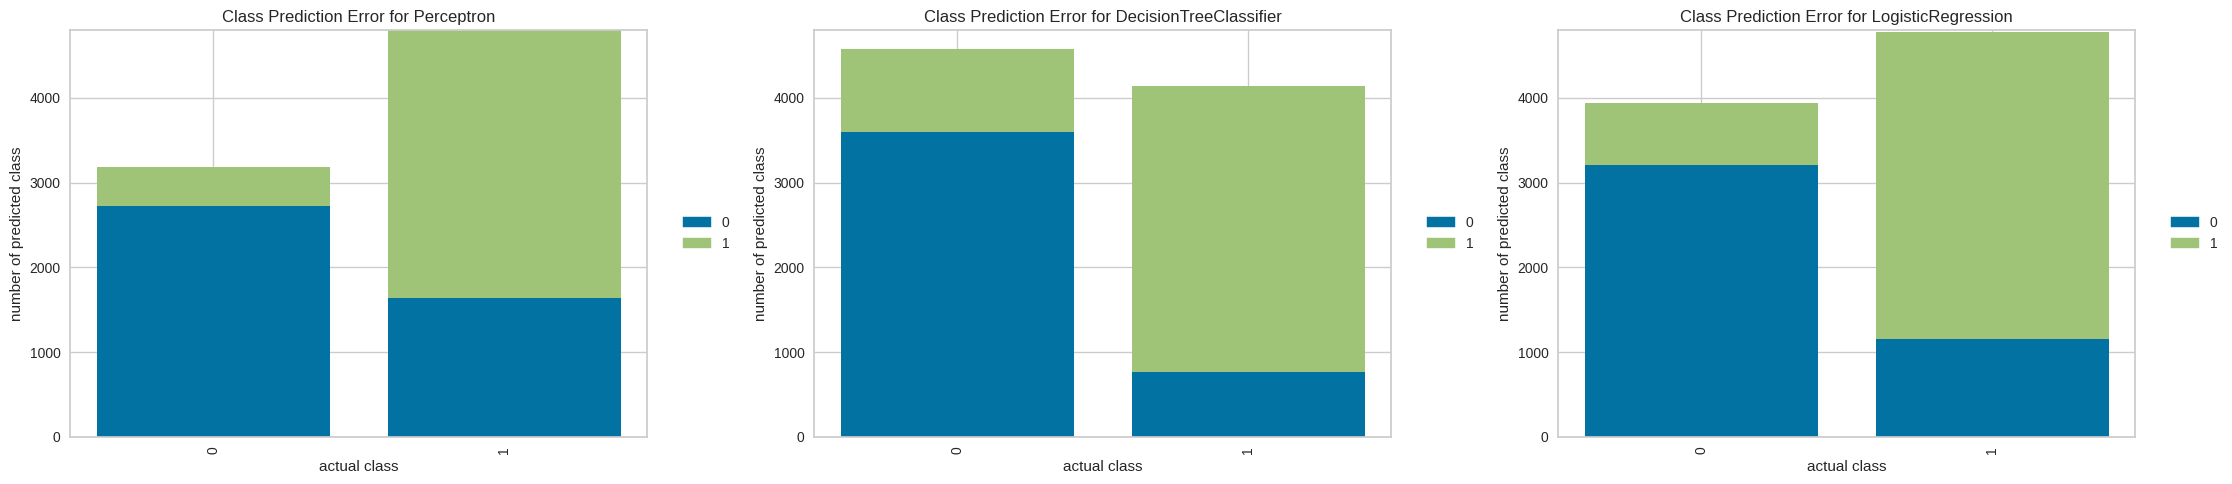

In [ ]:
fig, axe = plt.subplots(ncols=3,figsize=(25, 5))
fig.tight_layout(pad=8.0)
visualgrid = [ClassPredictionError(classifiers[0], classes=classes, ax=axe[0]),
              ClassPredictionError(classifiers[1], classes=classes, ax=axe[1]),
              ClassPredictionError(classifiers[2], classes=classes, ax=axe[2])]

for viz in visualgrid:
  viz.fit(X_train, Y_train)
  viz.score(X_train, Y_train)
  viz.finalize()

plt.show()

### Datos de validación

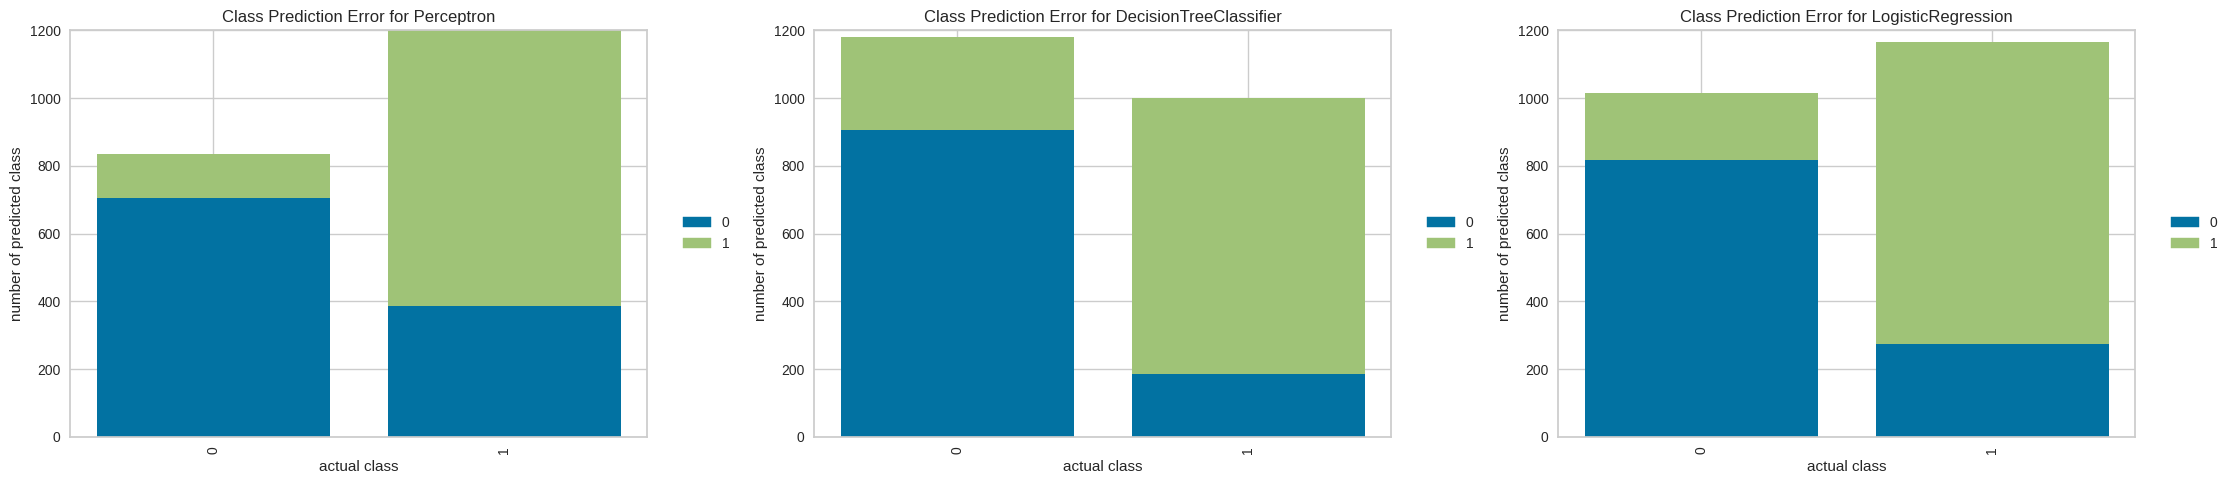

In [ ]:
fig, axe = plt.subplots(ncols=3,figsize=(25, 5))
fig.tight_layout(pad=8.0)
visualgrid = [ClassPredictionError(classifiers[0], classes=classes, ax=axe[0]),
              ClassPredictionError(classifiers[1], classes=classes, ax=axe[1]),
              ClassPredictionError(classifiers[2], classes=classes, ax=axe[2])]

for viz in visualgrid:
  viz.fit(X_train, Y_train)
  viz.score(X_test, Y_test)
  viz.finalize()

plt.show()